# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from tqdm import tqdm
from skimage.transform import resize
import torchvision.utils as vutils
from torchvision import transforms
from mpl_toolkits.axes_grid1 import ImageGrid

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Preprocess and Save

### Load Preporcessed Dataset

In [3]:
# loading images
images_l = load_obj_real("/work/kabaeuer/logs/imagenette_32_class/imagenette_images_sorted_100000")

50000


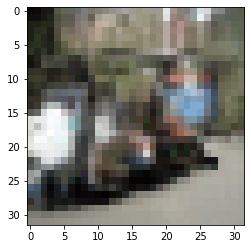

In [4]:
# Example image
print(len(images_l))
imgplot = plt.imshow(images_l[2])
plt.show()

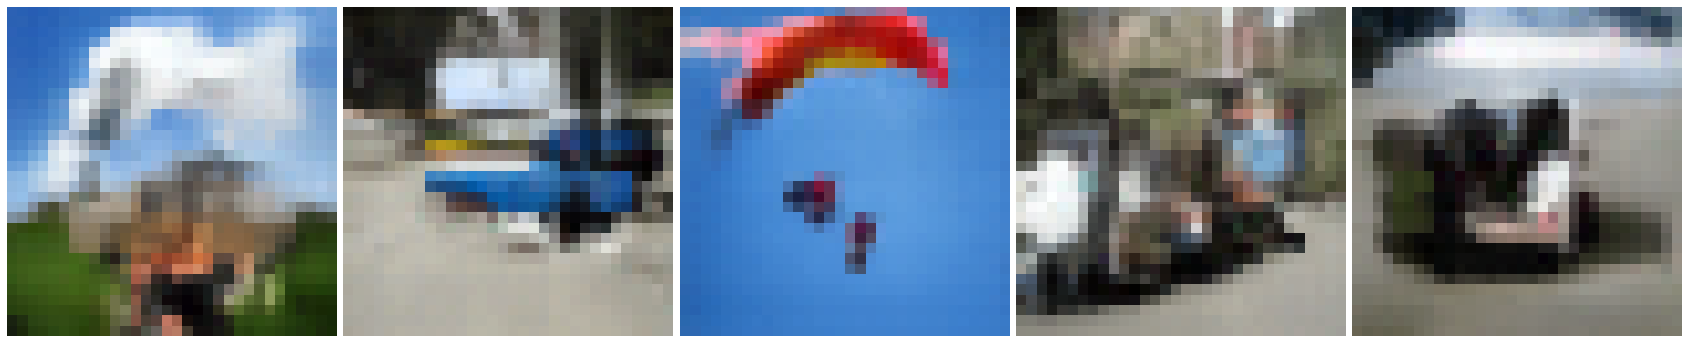

In [5]:
im1 = images_l[8]
im2 = images_l[99]
im3 = images_l[20]
im4 = images_l[2]
im5 = images_l[101]

fig = plt.figure(figsize=(30, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [im1, im2, im3, im4, im5]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.set_axis_off()
plt.show()

## Real Images

In [6]:
# create cifar order
#transforms_list_first = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
#first = dset.ImageFolder('/work/kabaeuer/data/imagenette2/', transform=transforms_list_first)
#data_loader_first = torch.utils.data.DataLoader(dataset=first, batch_size=1, num_workers=0)
#pbar = tqdm(enumerate(data_loader_first), total=len(data_loader_first))
#for batch_idx, (data, target) in pbar:
#    vutils.save_image(data.detach(),'/work/kabaeuer/data/imagenette_32/imgs/'+ str(batch_idx)+'.png',normalize=True)

In [7]:
#import os
#import imageio
#path = "/work/kabaeuer/data/imagenette_32/imgs"
#i=0
#list_dir=[int(file.split(".")[0]) for file in os.listdir(path)]
#list_dir.sort()
#print(len(list_dir))
#images_real = []
#for fname in list_dir:    
#    img = imageio.imread(path + '/' + str(fname)+".png")
#    images_real.append(img)
#save_obj(images_real,'/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images')

In [8]:
images_real = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images")

13260


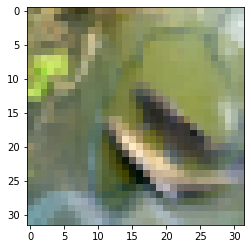

In [9]:
# Example image
print(len(images_real))
imgplot = plt.imshow(images_real[0])
plt.show()

# Analyzing Images

## Creating FFT

In [10]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

In [11]:
# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

### Generated Images

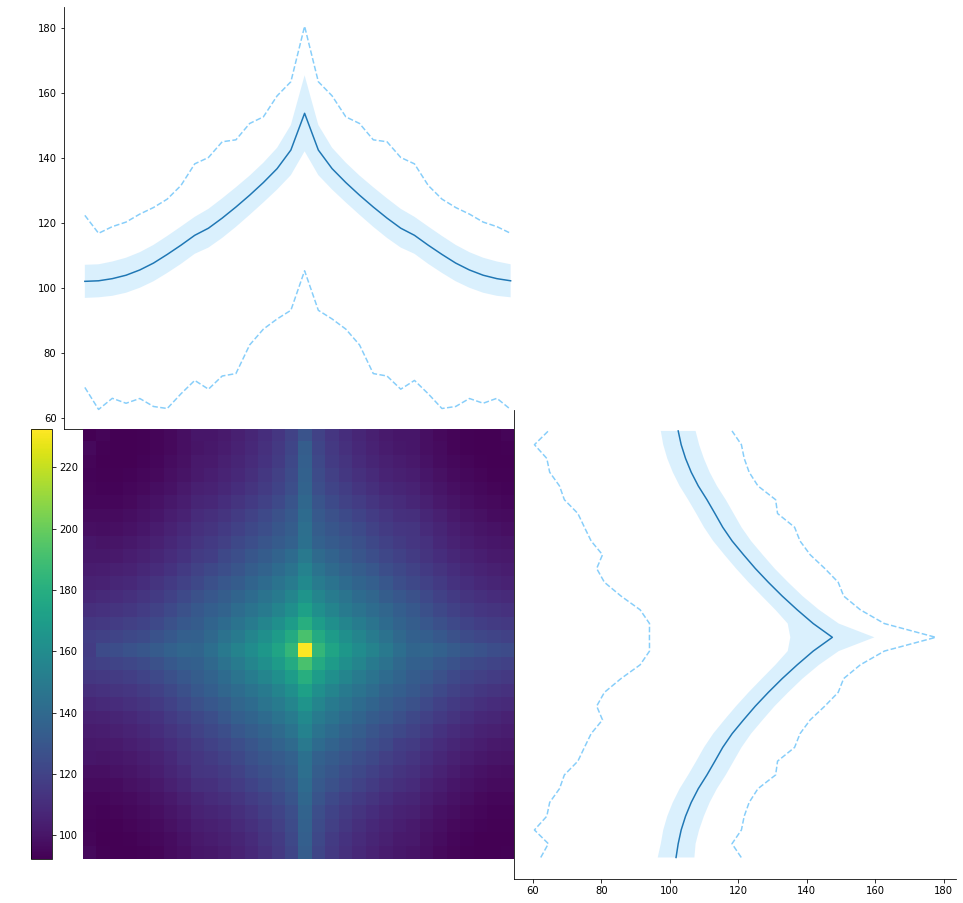

In [12]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g)

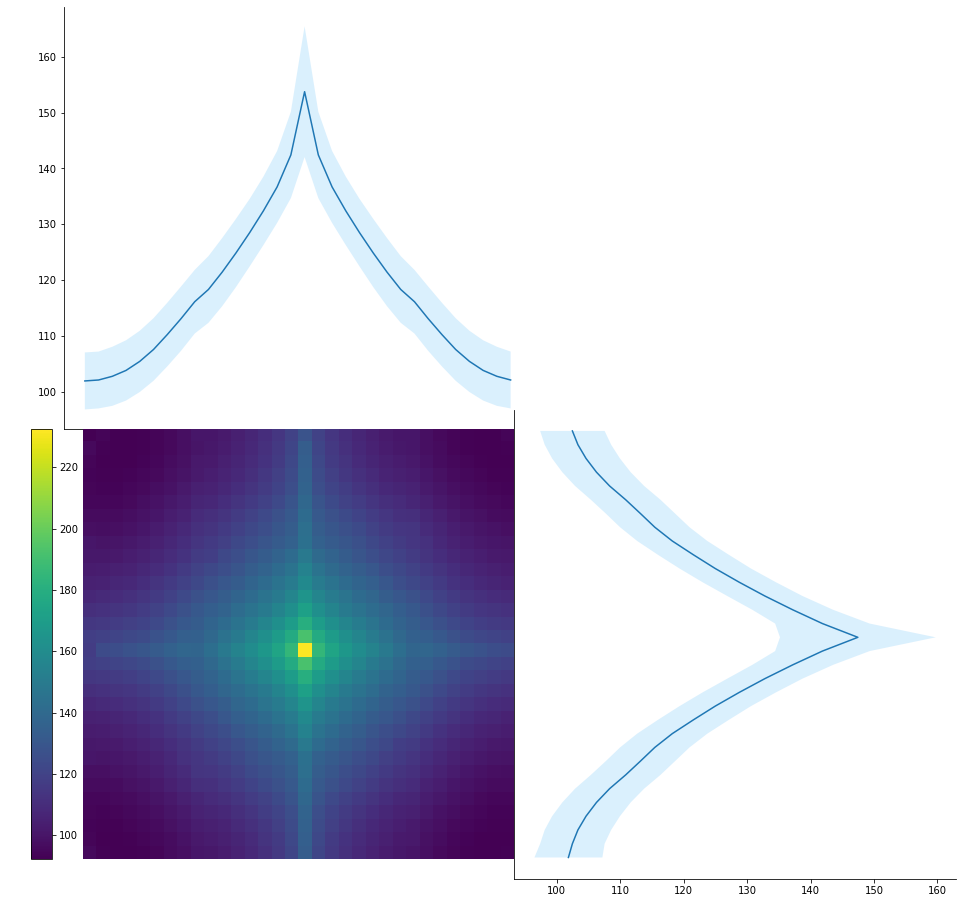

In [13]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Normalized

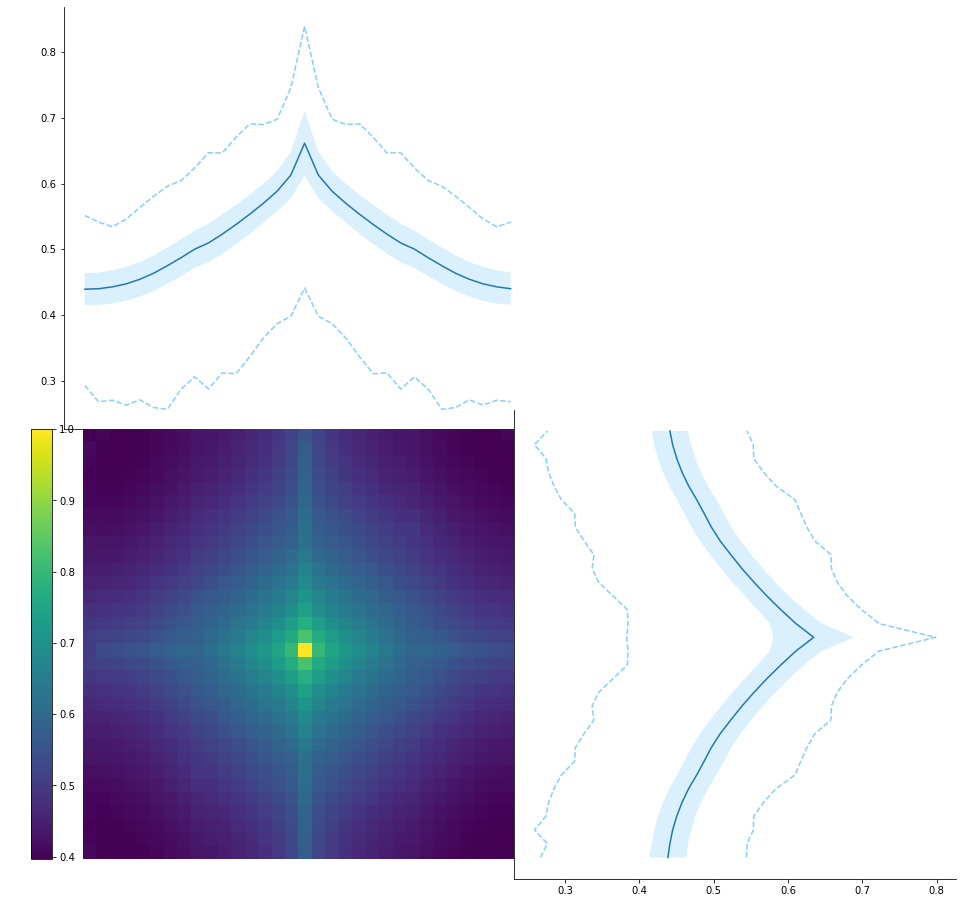

In [14]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,True)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = True)

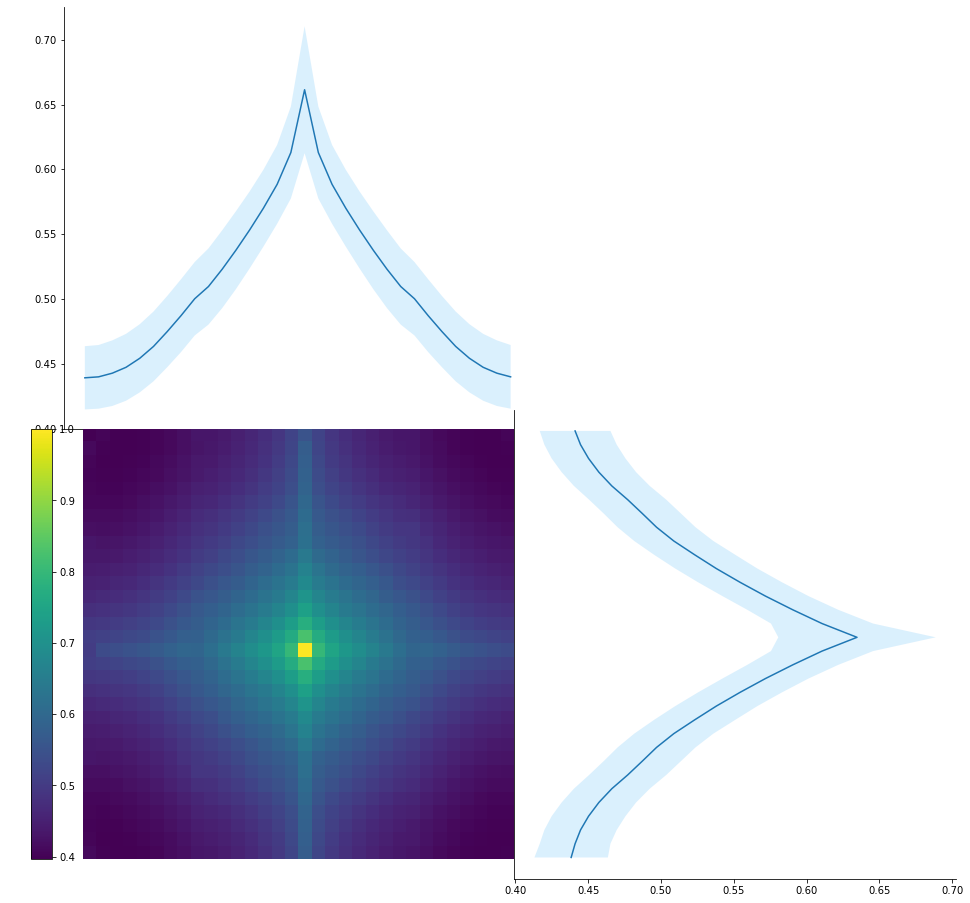

In [15]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l, True)
create_overview_plot(two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g, max_min = False)

### Real Images

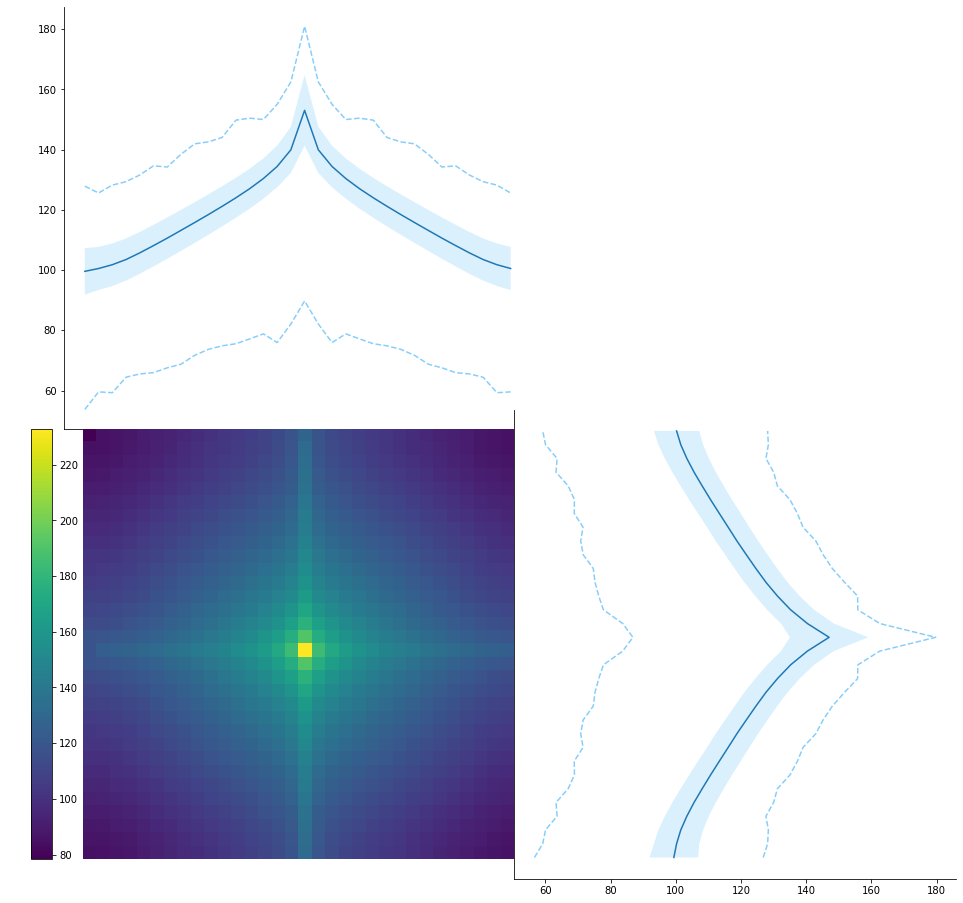

In [16]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

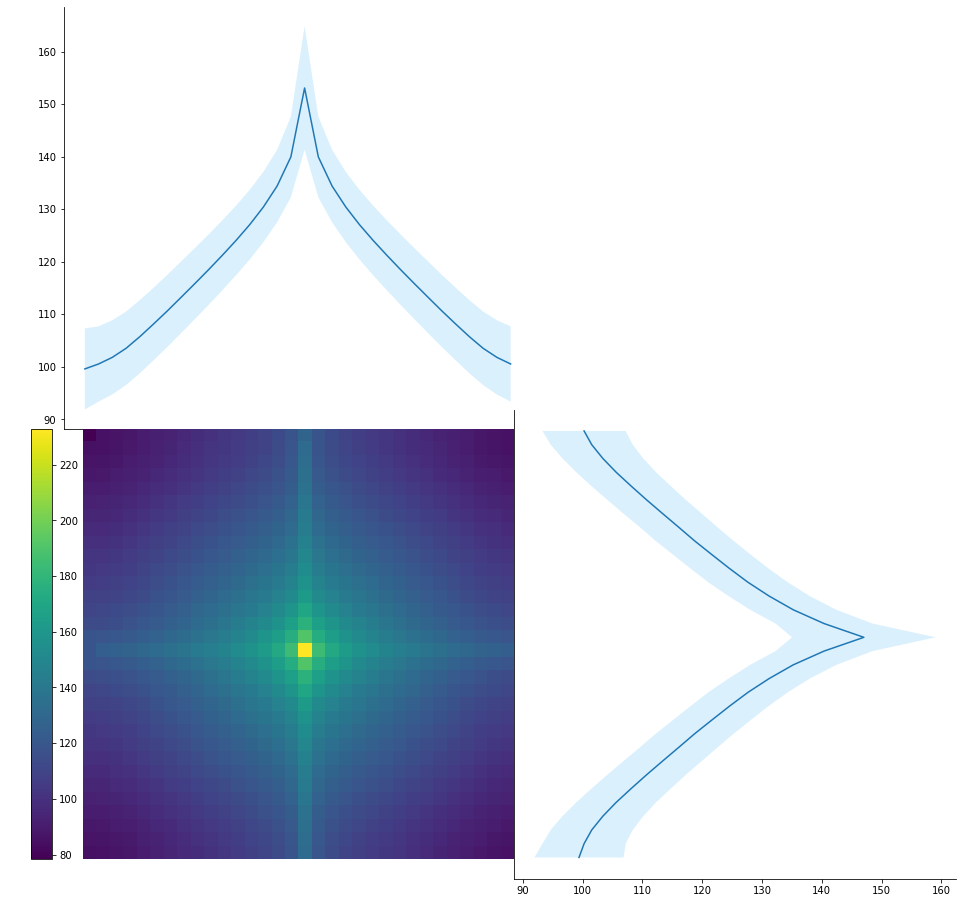

In [17]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Normalized

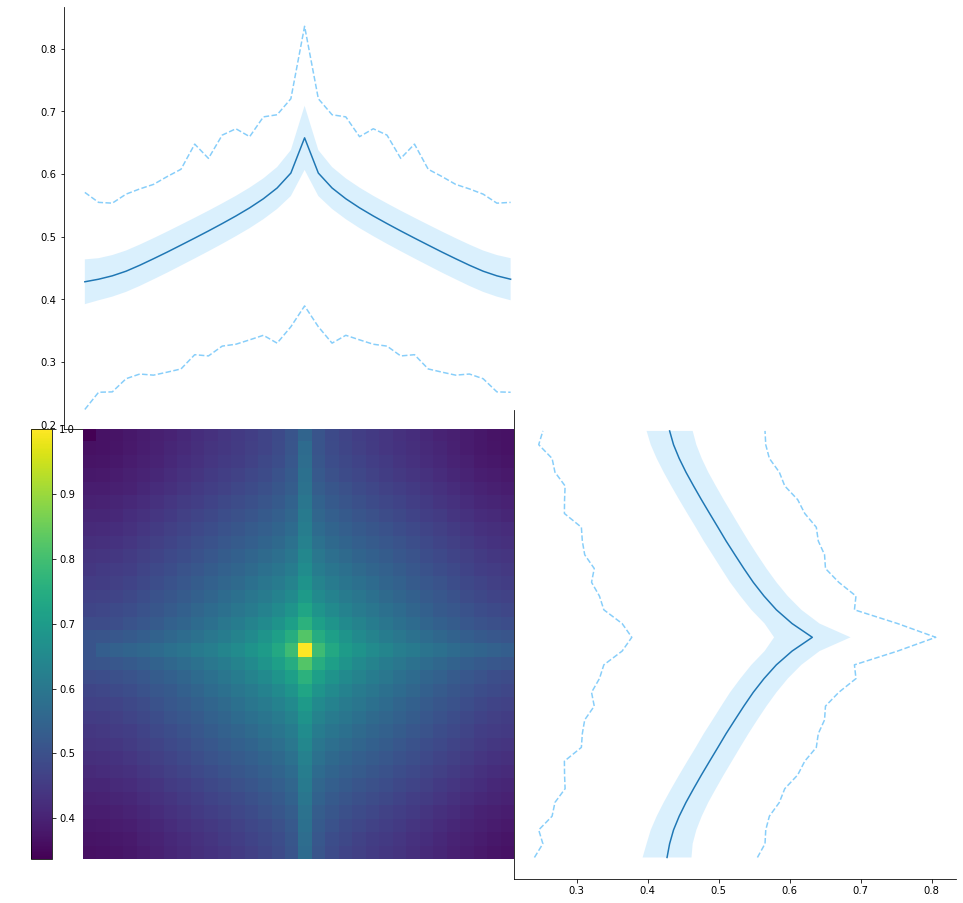

In [18]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real, True)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = True)

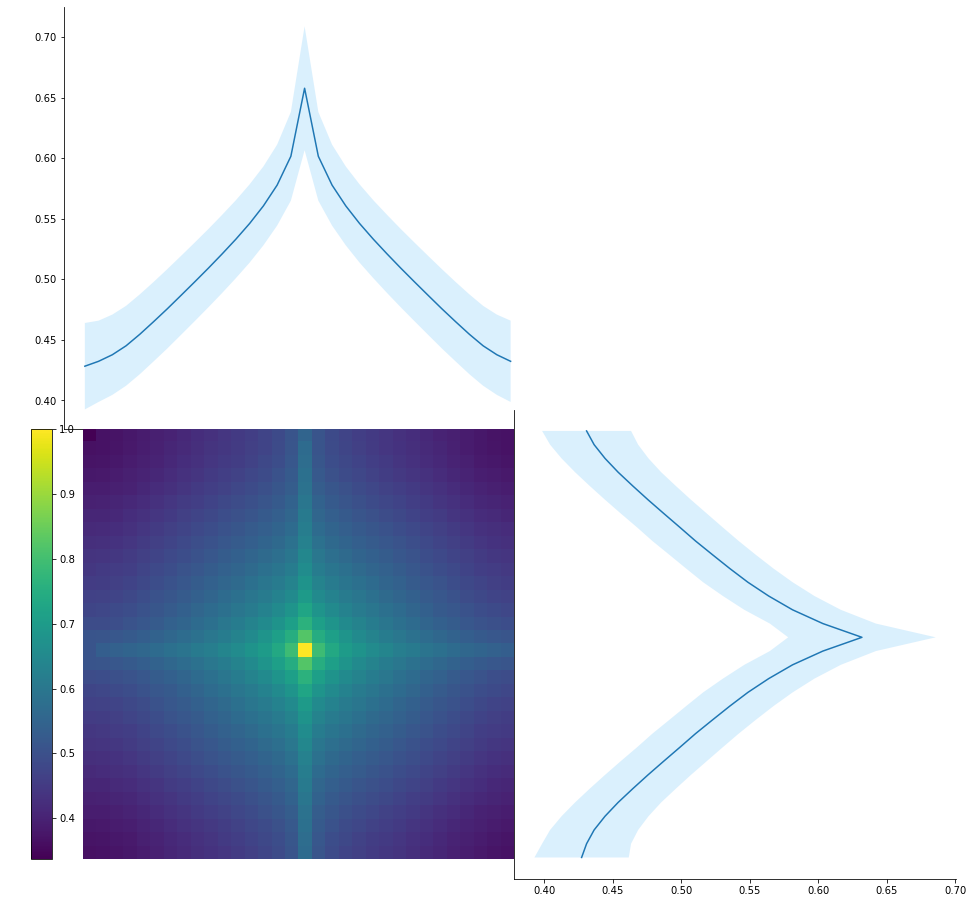

In [19]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real, True)
create_overview_plot(two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r, max_min = False)

### Real vs Fake

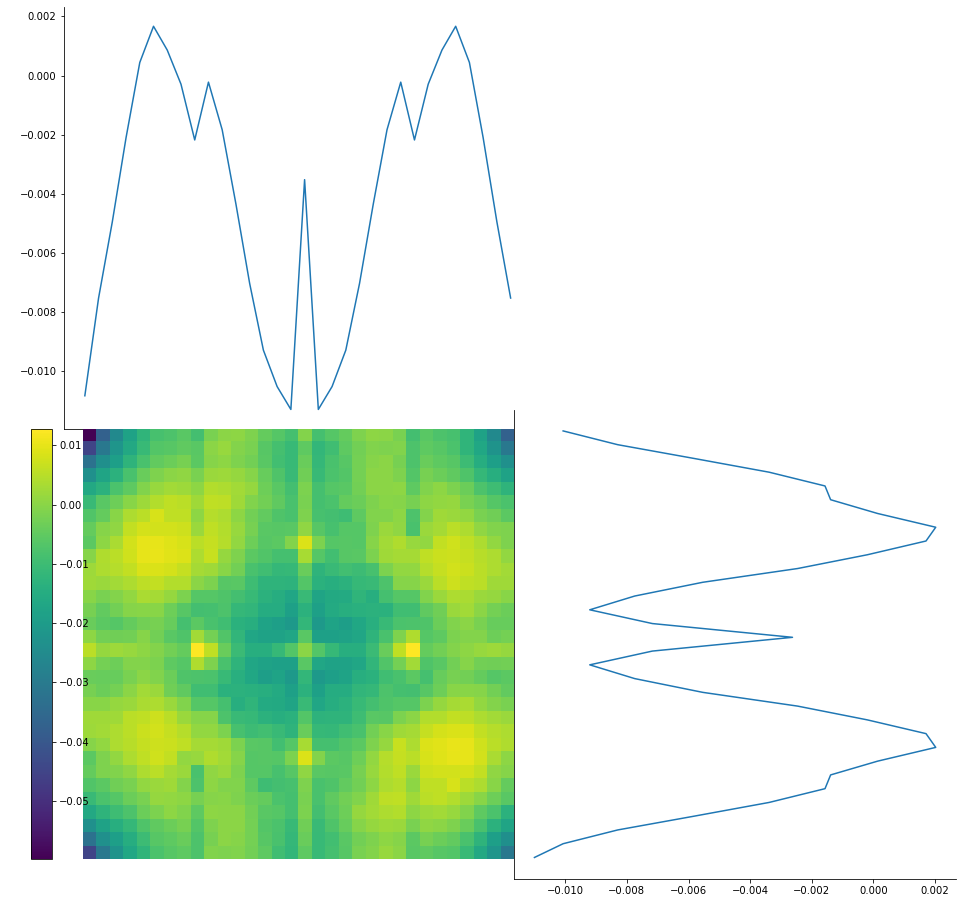

In [20]:
create_comparison_plot(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="Trans_pix")

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

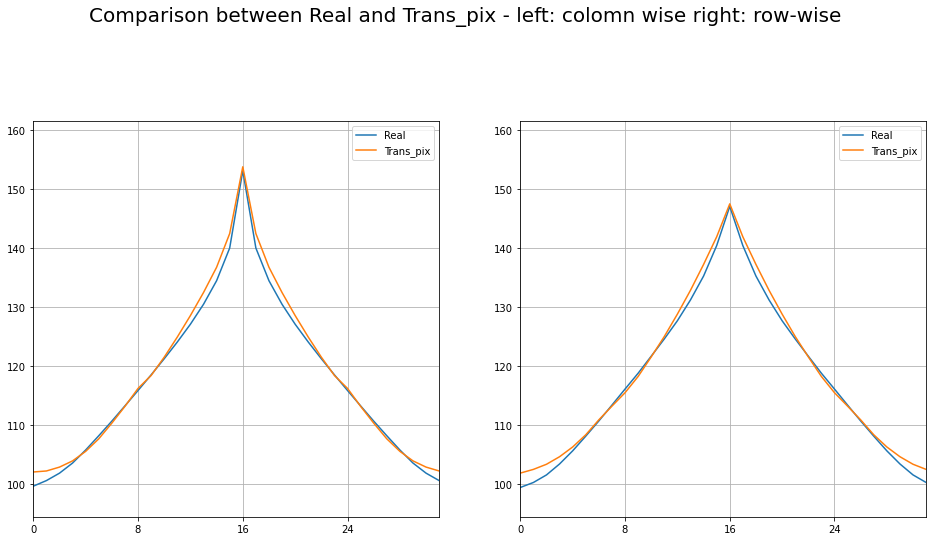

In [21]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.grid()
ax2.grid()
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g, label='Trans_pix')
ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g, label='Trans_pix')
ymin = min(min(zero_axis_r),min(zero_axis_g),min(one_axis_r),min(one_axis_g))
ymax = max(max(zero_axis_r),max(zero_axis_g),max(one_axis_r),max(one_axis_g))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

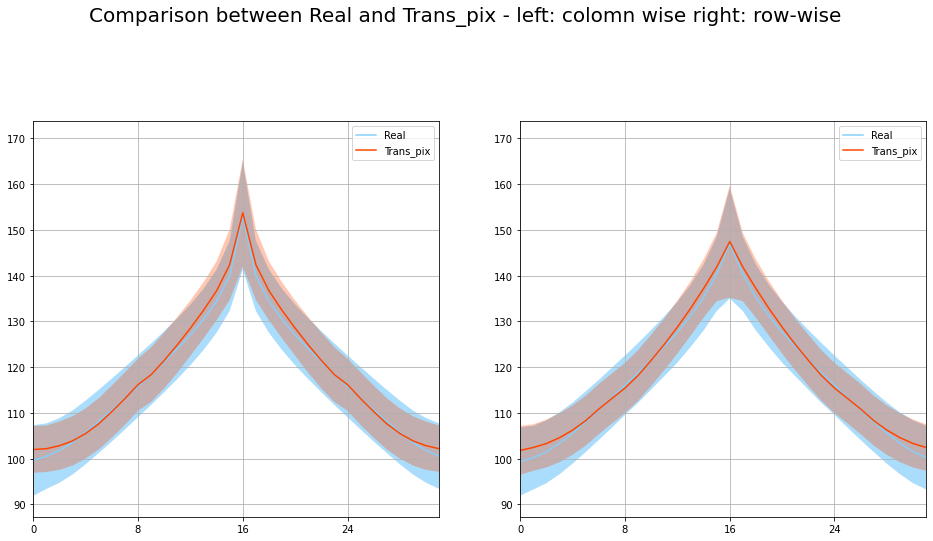

In [22]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_r)),zero_axis_g, label='Trans_pix', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g + std_zero_axis_g, zero_axis_g -std_zero_axis_g,facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_g)),one_axis_g, label='Trans_pix',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g + std_one_axis_g, one_axis_g -std_one_axis_g,facecolor='orangered', alpha=0.3)
leg = ax1.legend()
leg = ax2.legend()
ymin = min(min(zero_axis_r-std_zero_axis_r),min(zero_axis_g-std_zero_axis_g),min(one_axis_r-std_one_axis_r),min(one_axis_g-std_one_axis_g))
ymax = max(max(zero_axis_r+std_zero_axis_r),max(zero_axis_g+std_zero_axis_g),max(one_axis_r+std_one_axis_r),max(one_axis_g+std_one_axis_g))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

### Normalized

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

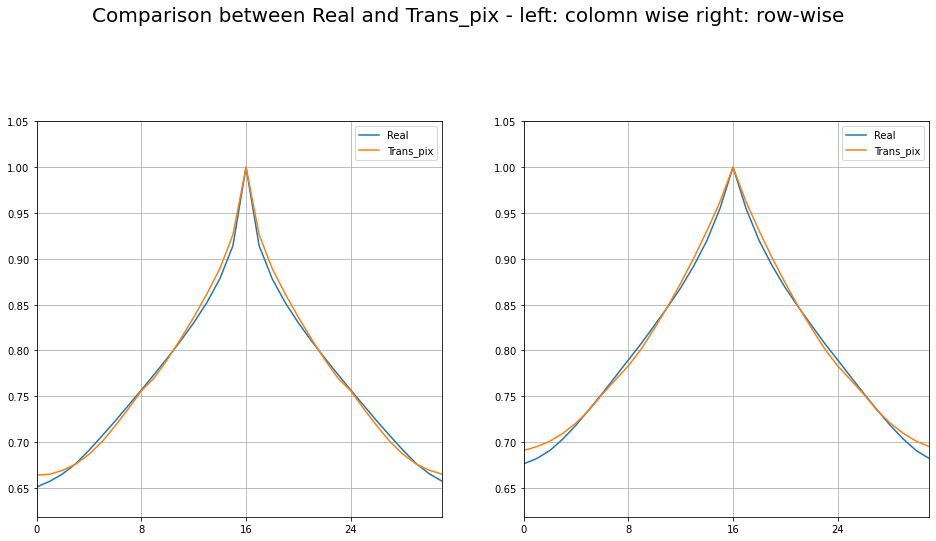

In [23]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_g)),zero_axis_g/zero_axis_g.max(), label='Trans_pix')
ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='Trans_pix')
ymin = min(min(zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max()))
ymax = max(max(zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max()))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real and Trans_pix - left: colomn wise right: row-wise')

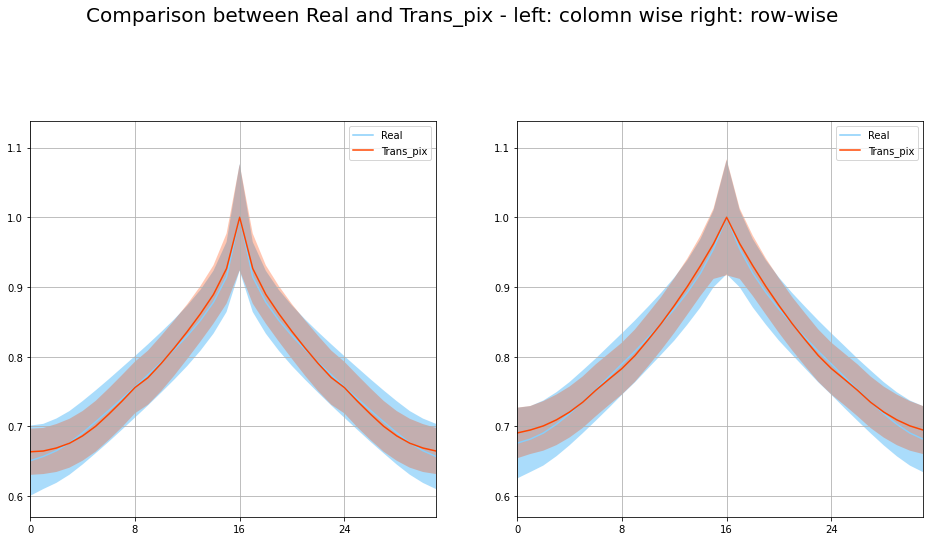

In [24]:
two_dim_g, zero_axis_g, one_axis_g, m_g, n_g,min_zero_axis_g,max_zero_axis_g, min_one_axis_g, max_one_axis_g, std_zero_axis_g, std_one_axis_g = create_informations(images_l,False)
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real,False)
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r/zero_axis_r.max() + std_zero_axis_r/zero_axis_r.max(), zero_axis_r/zero_axis_r.max() -std_zero_axis_r/zero_axis_r.max(),facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_r)),zero_axis_g/zero_axis_g.max(), label='Trans_pix', color ='orangered')
ax1.fill_between(range(m_g), zero_axis_g/zero_axis_g.max() + std_zero_axis_g/zero_axis_g.max(), zero_axis_g/zero_axis_g.max() -std_zero_axis_g/zero_axis_g.max(),facecolor='orangered', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r/one_axis_r.max() + std_one_axis_r/one_axis_r.max(), one_axis_r/one_axis_r.max() -std_one_axis_r/one_axis_r.max(),facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='Trans_pix',color = 'orangered')
ax2.fill_between(range(m_r), one_axis_g/one_axis_g.max() + std_one_axis_g/one_axis_g.max(), one_axis_g/one_axis_g.max() -std_one_axis_g/one_axis_g.max(),facecolor='orangered', alpha=0.3)

ymin = min(min(zero_axis_r/zero_axis_r.max() -std_zero_axis_r/zero_axis_r.max()),min(zero_axis_g/zero_axis_g.max() -std_zero_axis_g/zero_axis_g.max()),min(one_axis_r/one_axis_r.max() -std_one_axis_r/one_axis_r.max()),min(one_axis_g/one_axis_g.max() -std_one_axis_g/one_axis_g.max()))
ymax = max(max(zero_axis_r/zero_axis_r.max() + std_zero_axis_r/zero_axis_r.max()),max(zero_axis_g/zero_axis_g.max() + std_zero_axis_g/zero_axis_g.max()),max(one_axis_r/one_axis_r.max() + std_one_axis_r/one_axis_r.max()),max(one_axis_g/one_axis_g.max() + std_one_axis_g/one_axis_g.max()))
ax1.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
ax2.set(xlim=(0,31), ylim=(ymin*0.95, ymax*1.05))
leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.grid()
ax2.grid()
fig.suptitle("Comparison between Real and Trans_pix - left: colomn wise right: row-wise", fontsize=20)

### Real vs Fake relative

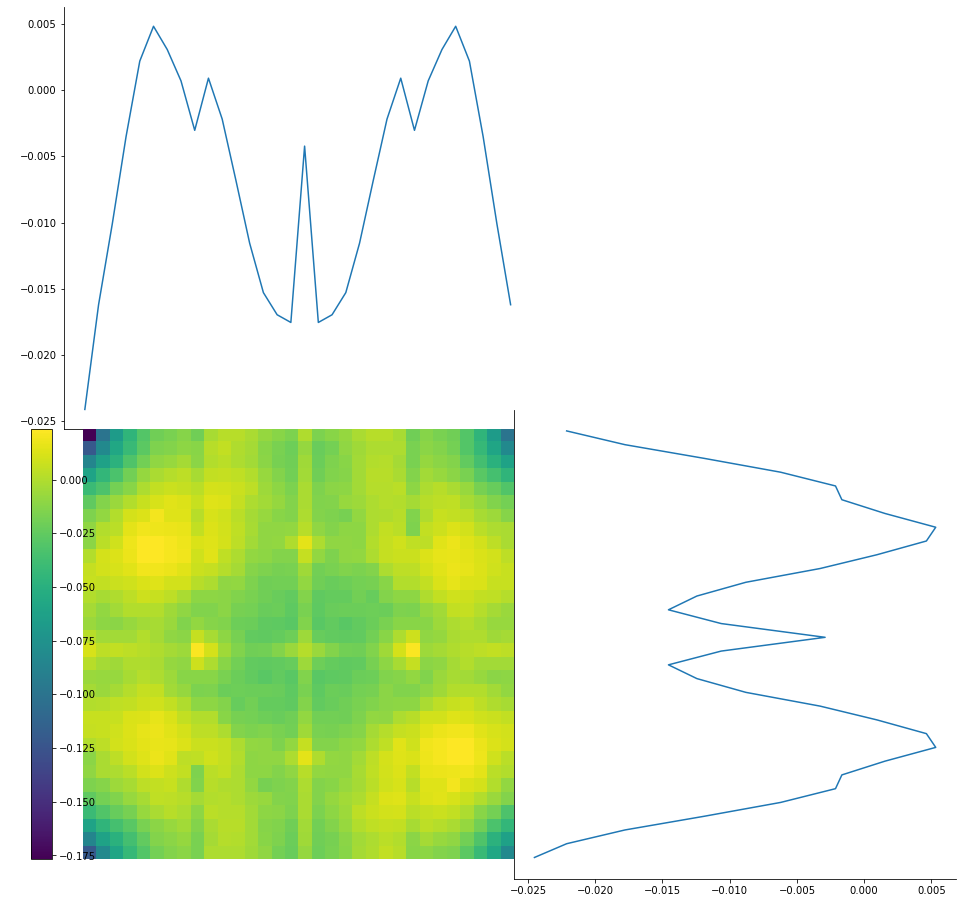

In [25]:
create_comparison_plot_rel(m_r,n_r, m_g,n_g,two_dim_r, zero_axis_r, one_axis_r,
                           two_dim_g, zero_axis_g, one_axis_g, name_1="Real", name_2="Trans_pix")

## FID-Calucluations

In [26]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(real_img, fake_img):
    
    mu1 = real_img.mean(axis=0)
    sigma1 = cov(real_img, rowvar=False)
    mu2 = fake_img.mean(axis=0)
    sigma2 = cov(fake_img, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [27]:
real_img = []
for _ in tqdm(range(int(len(images_real)))):
    real_img.extend([np.array(fft(images_real[_])).flatten()])
real_img = np.array(real_img)
fake_img = []
for _ in tqdm(range(int(len(images_l)))):
    fake_img.extend([np.array(fft(images_l[_])).flatten()])
fake_img = np.array(fake_img)
print("FID: ", calculate_fid(real_img,fake_img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:10<00:00, 4990.85it/s]


FID:  9715.149885424635


### Normalized

In [28]:
real_img = []
for _ in tqdm(range(int(len(images_real)))):
    real_img.extend([np.array(fft(images_real[_])).flatten()]/np.array(fft(images_real[_])).flatten().max())
real_img = np.array(real_img)
fake_img = []
for _ in tqdm(range(int(len(images_l)))):
    fake_img.extend([np.array(fft(images_l[_])).flatten()]/np.array(fft(images_l[_])).flatten().max())
fake_img = np.array(fake_img)
print("FID: ", calculate_fid(real_img,fake_img))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:19<00:00, 2580.71it/s]


FID:  0.1859304723898507


# Classify

### Real

In [29]:
classes = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/all_classified")
ordered_images = load_obj_real("/work/kabaeuer/AA_Experiment/Analysis/ImageNette/imagenette_images_sorted")

In [30]:
print(len(classes), len(ordered_images))

13260 13260


In [31]:
class_0 = []
class_1 = []
class_2 = []
class_3 = []
class_4 = []
class_5 = []
class_6 = []
class_7 = []
class_8 = []
class_9 = []



for i in range(len(classes)):
    if classes[i] == 0:
        class_0.append(ordered_images[i])
    elif classes[i] == 1:
        class_1.append(ordered_images[i])
    elif classes[i] == 2:
        class_2.append(ordered_images[i])
    elif classes[i] == 3:
        class_3.append(ordered_images[i])
    elif classes[i] == 4:
        class_4.append(ordered_images[i])
    elif classes[i] == 5:
        class_5.append(ordered_images[i])
    elif classes[i] == 6:
        class_6.append(ordered_images[i])
    elif classes[i] == 7:
        class_7.append(ordered_images[i])
    elif classes[i] == 8:
        class_8.append(ordered_images[i])
    elif classes[i] == 9:
        class_9.append(ordered_images[i])
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200


In [32]:
print(len(class_0),len(class_1),len(class_2),len(class_3),len(class_4),len(class_5),len(class_6),len(class_7),len(class_8),len(class_9))

1326 1136 1443 1299 1339 1076 1306 1309 1479 1547


In [33]:
len(class_0)+len(class_1)+len(class_2)+len(class_3)+len(class_4)+len(class_5)+len(class_6)+len(class_7)+len(class_8)+len(class_9)

13260

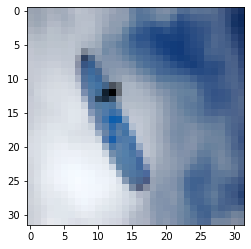

In [34]:
imgplot = plt.imshow(class_9[201])
plt.show()

[Text(0, 0, ''), Text(8, 0, ''), Text(16, 0, ''), Text(24, 0, '')]

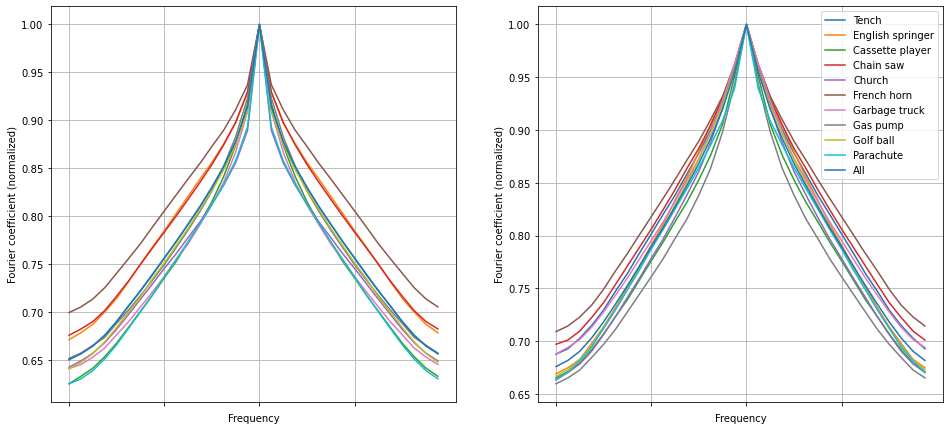

In [35]:
two_dim_0, zero_axis_0, one_axis_0, m_0, n_0,min_zero_axis_0,max_zero_axis_0, min_one_axis_0, max_one_axis_0, std_zero_axis_0, std_one_axis_0 = create_informations(class_0)
two_dim_1, zero_axis_1, one_axis_1, m_1, n_1,min_zero_axis_1,max_zero_axis_1, min_one_axis_1, max_one_axis_1, std_zero_axis_1, std_one_axis_1 = create_informations(class_1)
two_dim_2, zero_axis_2, one_axis_2, m_2, n_2,min_zero_axis_2,max_zero_axis_2, min_one_axis_2, max_one_axis_2, std_zero_axis_2, std_one_axis_2 = create_informations(class_2)
two_dim_3, zero_axis_3, one_axis_3, m_3, n_3,min_zero_axis_3,max_zero_axis_3, min_one_axis_3, max_one_axis_3, std_zero_axis_3, std_one_axis_3 = create_informations(class_3)
two_dim_4, zero_axis_4, one_axis_4, m_4, n_4,min_zero_axis_4,max_zero_axis_4, min_one_axis_4, max_one_axis_4, std_zero_axis_4, std_one_axis_4 = create_informations(class_4)
two_dim_5, zero_axis_5, one_axis_5, m_5, n_5,min_zero_axis_5,max_zero_axis_5, min_one_axis_5, max_one_axis_5, std_zero_axis_5, std_one_axis_5 = create_informations(class_5)
two_dim_6, zero_axis_6, one_axis_6, m_6, n_6,min_zero_axis_6,max_zero_axis_6, min_one_axis_6, max_one_axis_6, std_zero_axis_6, std_one_axis_6 = create_informations(class_6)
two_dim_7, zero_axis_7, one_axis_7, m_7, n_7,min_zero_axis_7,max_zero_axis_7, min_one_axis_7, max_one_axis_7, std_zero_axis_7, std_one_axis_7 = create_informations(class_7)
two_dim_8, zero_axis_8, one_axis_8, m_8, n_8,min_zero_axis_8,max_zero_axis_8, min_one_axis_8, max_one_axis_8, std_zero_axis_8, std_one_axis_8 = create_informations(class_8)
two_dim_9, zero_axis_9, one_axis_9, m_9, n_9,min_zero_axis_9,max_zero_axis_9, min_one_axis_9, max_one_axis_9, std_zero_axis_9, std_one_axis_9 = create_informations(class_9)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_0)),zero_axis_0/zero_axis_0.max(), label='Tench')
ax1.plot(range(len(zero_axis_1)),zero_axis_1/zero_axis_1.max(), label='English springer')
ax1.plot(range(len(zero_axis_2)),zero_axis_2/zero_axis_2.max(), label='Cassette player')
ax1.plot(range(len(zero_axis_3)),zero_axis_3/zero_axis_3.max(), label='Chain saw')
ax1.plot(range(len(zero_axis_4)),zero_axis_4/zero_axis_4.max(), label='Church')
ax1.plot(range(len(zero_axis_5)),zero_axis_5/zero_axis_5.max(), label='French horn')
ax1.plot(range(len(zero_axis_6)),zero_axis_6/zero_axis_6.max(), label='Garbage truck')
ax1.plot(range(len(zero_axis_7)),zero_axis_7/zero_axis_7.max(), label='Gas pump')
ax1.plot(range(len(zero_axis_8)),zero_axis_8/zero_axis_8.max(), label='Golf ball')
ax1.plot(range(len(zero_axis_9)),zero_axis_9/zero_axis_9.max(), label='Parachute')
ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='All')


ax2.plot(range(len(one_axis_0)),one_axis_0/one_axis_0.max(), label='Tench')
ax2.plot(range(len(one_axis_1)),one_axis_1/one_axis_1.max(), label='English springer')
ax2.plot(range(len(one_axis_2)),one_axis_2/one_axis_2.max(), label='Cassette player')
ax2.plot(range(len(one_axis_3)),one_axis_3/one_axis_3.max(), label='Chain saw')
ax2.plot(range(len(one_axis_4)),one_axis_4/one_axis_4.max(), label='Church')
ax2.plot(range(len(one_axis_5)),one_axis_5/one_axis_5.max(), label='French horn')
ax2.plot(range(len(one_axis_6)),one_axis_6/one_axis_6.max(), label='Garbage truck')
ax2.plot(range(len(one_axis_7)),one_axis_7/one_axis_7.max(), label='Gas pump')
ax2.plot(range(len(one_axis_8)),one_axis_8/one_axis_8.max(), label='Golf ball')
ax2.plot(range(len(one_axis_9)),one_axis_9/one_axis_9.max(), label='Parachute')
ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='All')

ax1.grid()
ax2.grid()

#leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])
#fig.suptitle("Comparison between classes Real (Normalized) - left: colomn wise right: row-wise", fontsize=20)

### Generated

#### TransGAN

In [36]:
classes_g_n = load_obj_real("/work/kabaeuer/logs/imagenette_32_2022_03_04_15_56_38/Samples/class/all_classified_trans")
ordered_images_g_n = load_obj_real("/work/kabaeuer/logs/imagenette_32_2022_03_04_15_56_38/Samples/class/imagenette_images_sorted_trans")

In [37]:
print(len(classes_g_n), len(ordered_images_g_n))

50000 50000


In [38]:
class_0_g_n = []
class_1_g_n = []
class_2_g_n = []
class_3_g_n = []
class_4_g_n = []
class_5_g_n = []
class_6_g_n = []
class_7_g_n = []
class_8_g_n = []
class_9_g_n = []



for i in range(len(classes_g_n)):
    if classes_g_n[i] == 0:
        class_0_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 1:
        class_1_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 2:
        class_2_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 3:
        class_3_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 4:
        class_4_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 5:
        class_5_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 6:
        class_6_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 7:
        class_7_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 8:
        class_8_g_n.append(ordered_images_g_n[i])
    elif classes_g_n[i] == 9:
        class_9_g_n.append(ordered_images_g_n[i])

In [39]:
print(len(class_0_g_n),len(class_1_g_n),len(class_2_g_n),len(class_3_g_n),len(class_4_g_n),len(class_5_g_n),len(class_6_g_n),len(class_7_g_n),len(class_8_g_n),len(class_9_g_n))

10152 3186 5216 3186 6004 1066 4489 4330 5430 6941


In [40]:
two_dim_0_g_n, zero_axis_0_g_n, one_axis_0_g_n, m_0_g_n, n_0_g_n,min_zero_axis_0_g_n,max_zero_axis_0_g_n, min_one_axis_0_g_n, max_one_axis_0_g_n, std_zero_axis_0_g_n, std_one_axis_0_g_n = create_informations(class_0_g_n)
two_dim_1_g_n, zero_axis_1_g_n, one_axis_1_g_n, m_1_g_n, n_1_g_n,min_zero_axis_1_g_n,max_zero_axis_1_g_n, min_one_axis_1_g_n, max_one_axis_1_g_n, std_zero_axis_1_g_n, std_one_axis_1_g_n = create_informations(class_1_g_n)
two_dim_2_g_n, zero_axis_2_g_n, one_axis_2_g_n, m_2_g_n, n_2_g_n,min_zero_axis_2_g_n,max_zero_axis_2_g_n, min_one_axis_2_g_n, max_one_axis_2_g_n, std_zero_axis_2_g_n, std_one_axis_2_g_n = create_informations(class_2_g_n)
two_dim_3_g_n, zero_axis_3_g_n, one_axis_3_g_n, m_3_g_n, n_3_g_n,min_zero_axis_3_g_n,max_zero_axis_3_g_n, min_one_axis_3_g_n, max_one_axis_3_g_n, std_zero_axis_3_g_n, std_one_axis_3_g_n = create_informations(class_3_g_n)
two_dim_4_g_n, zero_axis_4_g_n, one_axis_4_g_n, m_4_g_n, n_4_g_n,min_zero_axis_4_g_n,max_zero_axis_4_g_n, min_one_axis_4_g_n, max_one_axis_4_g_n, std_zero_axis_4_g_n, std_one_axis_4_g_n = create_informations(class_4_g_n)
two_dim_5_g_n, zero_axis_5_g_n, one_axis_5_g_n, m_5_g_n, n_5_g_n,min_zero_axis_5_g_n,max_zero_axis_5_g_n, min_one_axis_5_g_n, max_one_axis_5_g_n, std_zero_axis_5_g_n, std_one_axis_5_g_n = create_informations(class_5_g_n)
two_dim_6_g_n, zero_axis_6_g_n, one_axis_6_g_n, m_6_g_n, n_6_g_n,min_zero_axis_6_g_n,max_zero_axis_6_g_n, min_one_axis_6_g_n, max_one_axis_6_g_n, std_zero_axis_6_g_n, std_one_axis_6_g_n = create_informations(class_6_g_n)
two_dim_7_g_n, zero_axis_7_g_n, one_axis_7_g_n, m_7_g_n, n_7_g_n,min_zero_axis_7_g_n,max_zero_axis_7_g_n, min_one_axis_7_g_n, max_one_axis_7_g_n, std_zero_axis_7_g_n, std_one_axis_7_g_n = create_informations(class_7_g_n)
two_dim_8_g_n, zero_axis_8_g_n, one_axis_8_g_n, m_8_g_n, n_8_g_n,min_zero_axis_8_g_n,max_zero_axis_8_g_n, min_one_axis_8_g_n, max_one_axis_8_g_n, std_zero_axis_8_g_n, std_one_axis_8_g_n = create_informations(class_8_g_n)
two_dim_9_g_n, zero_axis_9_g_n, one_axis_9_g_n, m_9_g_n, n_9_g_n,min_zero_axis_9_g_n,max_zero_axis_9_g_n, min_one_axis_9_g_n, max_one_axis_9_g_n, std_zero_axis_9_g_n, std_one_axis_9_g_n = create_informations(class_9_g_n)

#### TransGAN_class

In [41]:
classes_g = load_obj_real("/work/kabaeuer/logs/imagenette_32_class/all_classified_100000")
ordered_images_g = load_obj_real("/work/kabaeuer/logs/imagenette_32_class/imagenette_images_sorted_100000")

In [42]:
print(len(classes_g), len(ordered_images_g))

50000 50000


In [43]:
class_0_g = []
class_1_g = []
class_2_g = []
class_3_g = []
class_4_g = []
class_5_g = []
class_6_g = []
class_7_g = []
class_8_g = []
class_9_g = []



for i in range(len(classes_g)):
    if classes_g[i] == 0:
        class_0_g.append(ordered_images_g[i])
    elif classes_g[i] == 1:
        class_1_g.append(ordered_images_g[i])
    elif classes_g[i] == 2:
        class_2_g.append(ordered_images_g[i])
    elif classes_g[i] == 3:
        class_3_g.append(ordered_images_g[i])
    elif classes_g[i] == 4:
        class_4_g.append(ordered_images_g[i])
    elif classes_g[i] == 5:
        class_5_g.append(ordered_images_g[i])
    elif classes_g[i] == 6:
        class_6_g.append(ordered_images_g[i])
    elif classes_g[i] == 7:
        class_7_g.append(ordered_images_g[i])
    elif classes_g[i] == 8:
        class_8_g.append(ordered_images_g[i])
    elif classes_g[i] == 9:
        class_9_g.append(ordered_images_g[i])

In [44]:
print(len(class_0_g),len(class_1_g),len(class_2_g),len(class_3_g),len(class_4_g),len(class_5_g),len(class_6_g),len(class_7_g),len(class_8_g),len(class_9_g))

9913 2516 5353 2919 4990 729 4742 5353 6386 7099


[Text(0, 0, ''), Text(8, 0, ''), Text(16, 0, ''), Text(24, 0, '')]

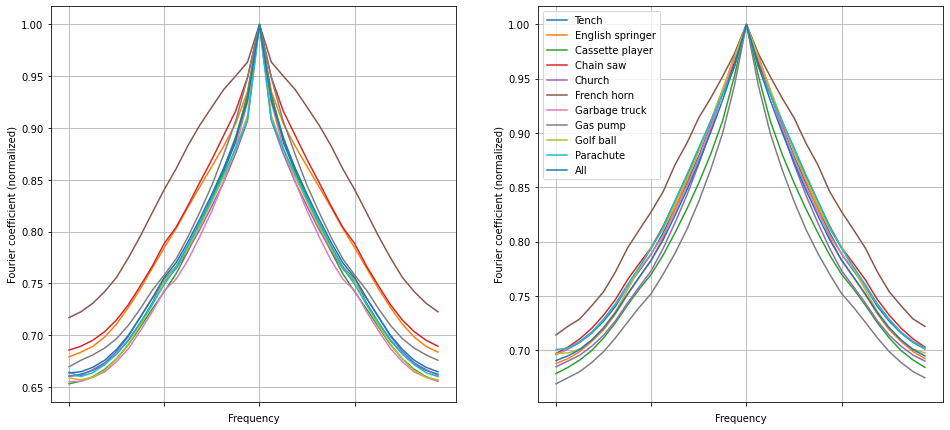

In [45]:
two_dim_0_g, zero_axis_0_g, one_axis_0_g, m_0_g, n_0_g,min_zero_axis_0_g,max_zero_axis_0_g, min_one_axis_0_g, max_one_axis_0_g, std_zero_axis_0_g, std_one_axis_0_g = create_informations(class_0_g)
two_dim_1_g, zero_axis_1_g, one_axis_1_g, m_1_g, n_1_g,min_zero_axis_1_g,max_zero_axis_1_g, min_one_axis_1_g, max_one_axis_1_g, std_zero_axis_1_g, std_one_axis_1_g = create_informations(class_1_g)
two_dim_2_g, zero_axis_2_g, one_axis_2_g, m_2_g, n_2_g,min_zero_axis_2_g,max_zero_axis_2_g, min_one_axis_2_g, max_one_axis_2_g, std_zero_axis_2_g, std_one_axis_2_g = create_informations(class_2_g)
two_dim_3_g, zero_axis_3_g, one_axis_3_g, m_3_g, n_3_g,min_zero_axis_3_g,max_zero_axis_3_g, min_one_axis_3_g, max_one_axis_3_g, std_zero_axis_3_g, std_one_axis_3_g = create_informations(class_3_g)
two_dim_4_g, zero_axis_4_g, one_axis_4_g, m_4_g, n_4_g,min_zero_axis_4_g,max_zero_axis_4_g, min_one_axis_4_g, max_one_axis_4_g, std_zero_axis_4_g, std_one_axis_4_g = create_informations(class_4_g)
two_dim_5_g, zero_axis_5_g, one_axis_5_g, m_5_g, n_5_g,min_zero_axis_5_g,max_zero_axis_5_g, min_one_axis_5_g, max_one_axis_5_g, std_zero_axis_5_g, std_one_axis_5_g = create_informations(class_5_g)
two_dim_6_g, zero_axis_6_g, one_axis_6_g, m_6_g, n_6_g,min_zero_axis_6_g,max_zero_axis_6_g, min_one_axis_6_g, max_one_axis_6_g, std_zero_axis_6_g, std_one_axis_6_g = create_informations(class_6_g)
two_dim_7_g, zero_axis_7_g, one_axis_7_g, m_7_g, n_7_g,min_zero_axis_7_g,max_zero_axis_7_g, min_one_axis_7_g, max_one_axis_7_g, std_zero_axis_7_g, std_one_axis_7_g = create_informations(class_7_g)
two_dim_8_g, zero_axis_8_g, one_axis_8_g, m_8_g, n_8_g,min_zero_axis_8_g,max_zero_axis_8_g, min_one_axis_8_g, max_one_axis_8_g, std_zero_axis_8_g, std_one_axis_8_g = create_informations(class_8_g)
two_dim_9_g, zero_axis_9_g, one_axis_9_g, m_9_g, n_9_g,min_zero_axis_9_g,max_zero_axis_9_g, min_one_axis_9_g, max_one_axis_9_g, std_zero_axis_9_g, std_one_axis_9_g = create_informations(class_9_g)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_0_g)),zero_axis_0_g/zero_axis_0_g.max(), label='Tench')
ax1.plot(range(len(zero_axis_1_g)),zero_axis_1_g/zero_axis_1_g.max(), label='English springer')
ax1.plot(range(len(zero_axis_2_g)),zero_axis_2_g/zero_axis_2_g.max(), label='Cassette player')
ax1.plot(range(len(zero_axis_3_g)),zero_axis_3_g/zero_axis_3_g.max(), label='Chain saw')
ax1.plot(range(len(zero_axis_4_g)),zero_axis_4_g/zero_axis_4_g.max(), label='Church')
ax1.plot(range(len(zero_axis_5_g)),zero_axis_5_g/zero_axis_5_g.max(), label='French horn')
ax1.plot(range(len(zero_axis_6_g)),zero_axis_6_g/zero_axis_6_g.max(), label='Garbage truck')
ax1.plot(range(len(zero_axis_7_g)),zero_axis_7_g/zero_axis_7_g.max(), label='Gas pump')
ax1.plot(range(len(zero_axis_8_g)),zero_axis_8_g/zero_axis_8_g.max(), label='Golf ball')
ax1.plot(range(len(zero_axis_9_g)),zero_axis_9_g/zero_axis_9_g.max(), label='Parachute')
ax1.plot(range(len(zero_axis_g)),zero_axis_g/zero_axis_g.max(), label='All')


ax2.plot(range(len(one_axis_0_g)),one_axis_0_g/one_axis_0_g.max(), label='Tench')
ax2.plot(range(len(one_axis_1_g)),one_axis_1_g/one_axis_1_g.max(), label='English springer')
ax2.plot(range(len(one_axis_2_g)),one_axis_2_g/one_axis_2_g.max(), label='Cassette player')
ax2.plot(range(len(one_axis_3_g)),one_axis_3_g/one_axis_3_g.max(), label='Chain saw')
ax2.plot(range(len(one_axis_4_g)),one_axis_4_g/one_axis_4_g.max(), label='Church')
ax2.plot(range(len(one_axis_5_g)),one_axis_5_g/one_axis_5_g.max(), label='French horn')
ax2.plot(range(len(one_axis_6_g)),one_axis_6_g/one_axis_6_g.max(), label='Garbage truck')
ax2.plot(range(len(one_axis_7_g)),one_axis_7_g/one_axis_7_g.max(), label='Gas pump')
ax2.plot(range(len(one_axis_8_g)),one_axis_8_g/one_axis_8_g.max(), label='Golf ball')
ax2.plot(range(len(one_axis_9_g)),one_axis_9_g/one_axis_9_g.max(), label='Parachute')
ax2.plot(range(len(one_axis_g)),one_axis_g/one_axis_g.max(), label='All')

ax1.grid()
ax2.grid()

#leg = ax1.legend()
leg = ax2.legend()
ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax2.set_xlabel('Frequency')
ax1.set_xticklabels([])
ax2.set_xticklabels([])
#fig.suptitle("Comparison between classes Generated_Class(Normalized) - left: colomn wise right: row-wise", fontsize=20)

### Per Class comparison:

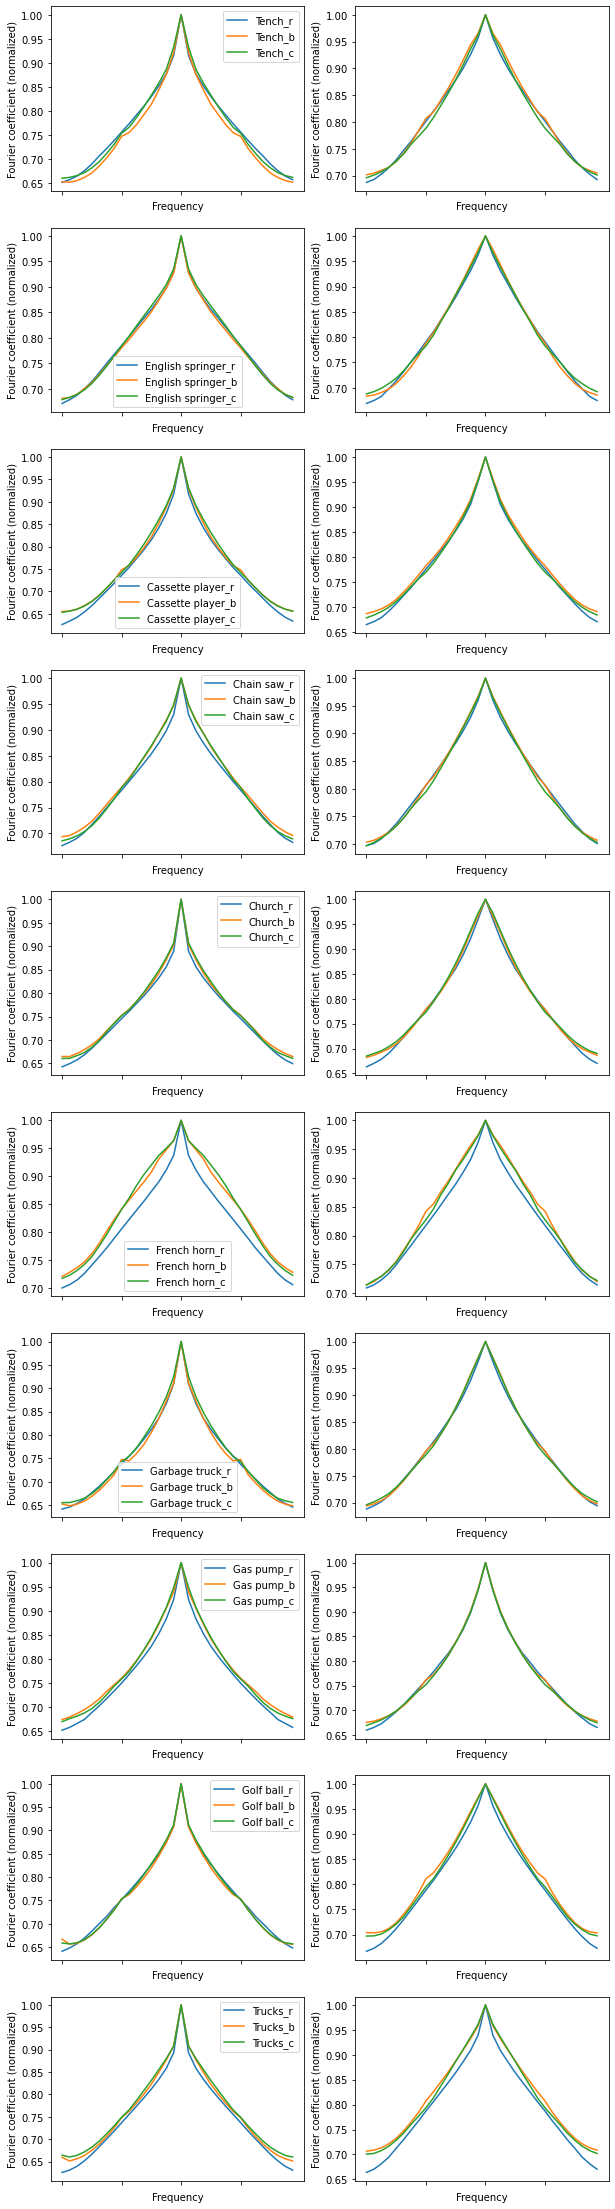

In [46]:
fig, ax = plt.subplots(10, 2)
fig.set_size_inches(10, 40)
ax1 = plt.subplot(10, 2, 1)
ax2 = plt.subplot(10, 2, 2)
ax3 = plt.subplot(10, 2, 3)
ax4 = plt.subplot(10, 2, 4)
ax5 = plt.subplot(10, 2, 5)
ax6 = plt.subplot(10, 2, 6)
ax7 = plt.subplot(10, 2, 7)
ax8 = plt.subplot(10, 2, 8)
ax9 = plt.subplot(10, 2, 9)
ax10 = plt.subplot(10, 2, 10)
ax11 = plt.subplot(10, 2, 11)
ax12 = plt.subplot(10, 2, 12)
ax13 = plt.subplot(10, 2, 13)
ax14 = plt.subplot(10, 2, 14)
ax15 = plt.subplot(10, 2, 15)
ax16 = plt.subplot(10, 2, 16)
ax17 = plt.subplot(10, 2, 17)
ax18 = plt.subplot(10, 2, 18)
ax19 = plt.subplot(10, 2, 19)
ax20 = plt.subplot(10, 2, 20)

ax1.plot(range(len(zero_axis_0)),zero_axis_0/zero_axis_0.max(), label='Tench_r')
ax1.plot(range(len(zero_axis_0_g_n)),zero_axis_0_g_n/zero_axis_0_g_n.max(), label='Tench_b')
ax1.plot(range(len(zero_axis_0_g)),zero_axis_0_g/zero_axis_0_g.max(), label='Tench_c')
ax2.plot(range(len(one_axis_0)),one_axis_0/one_axis_0.max(), label='Tench_r')
ax2.plot(range(len(one_axis_0_g_n)),one_axis_0_g_n/one_axis_0_g_n.max(), label='Tench_b')
ax2.plot(range(len(one_axis_0_g)),one_axis_0_g/one_axis_0_g.max(), label='Tench_c')


ax3.plot(range(len(zero_axis_1)),zero_axis_1/zero_axis_1.max(), label='English springer_r')
ax3.plot(range(len(zero_axis_1_g_n)),zero_axis_1_g_n/zero_axis_1_g_n.max(), label='English springer_b')
ax3.plot(range(len(zero_axis_1_g)),zero_axis_1_g/zero_axis_1_g.max(), label='English springer_c')
ax4.plot(range(len(one_axis_1)),one_axis_1/one_axis_1.max(), label='English springer_r')
ax4.plot(range(len(one_axis_1_g_n)),one_axis_1_g_n/one_axis_1_g_n.max(), label='English springer_b')
ax4.plot(range(len(one_axis_1_g)),one_axis_1_g/one_axis_1_g.max(), label='English springer_c')


ax5.plot(range(len(zero_axis_2)),zero_axis_2/zero_axis_2.max(), label='Cassette player_r')
ax5.plot(range(len(zero_axis_2_g_n)),zero_axis_2_g_n/zero_axis_2_g_n.max(), label='Cassette player_b')
ax5.plot(range(len(zero_axis_2_g)),zero_axis_2_g/zero_axis_2_g.max(), label='Cassette player_c')
ax6.plot(range(len(one_axis_2)),one_axis_2/one_axis_2.max(), label='Cassette player_r')
ax6.plot(range(len(one_axis_2_g_n)),one_axis_2_g_n/one_axis_2_g_n.max(), label='Cassette player_b')
ax6.plot(range(len(one_axis_2_g)),one_axis_2_g/one_axis_2_g.max(), label='Cassette player_c')

ax7.plot(range(len(zero_axis_3)),zero_axis_3/zero_axis_3.max(), label='Chain saw_r')
ax7.plot(range(len(zero_axis_3_g_n)),zero_axis_3_g_n/zero_axis_3_g_n.max(), label='Chain saw_b')
ax7.plot(range(len(zero_axis_3_g)),zero_axis_3_g/zero_axis_3_g.max(), label='Chain saw_c')
ax8.plot(range(len(one_axis_3)),one_axis_3/one_axis_3.max(), label='Chain saw_r')
ax8.plot(range(len(one_axis_3_g_n)),one_axis_3_g_n/one_axis_3_g_n.max(), label='Chain saw_b')
ax8.plot(range(len(one_axis_3_g)),one_axis_3_g/one_axis_3_g.max(), label='Chain saw_c')

ax9.plot(range(len(zero_axis_4)),zero_axis_4/zero_axis_4.max(), label='Church_r')
ax9.plot(range(len(zero_axis_4_g_n)),zero_axis_4_g_n/zero_axis_4_g_n.max(), label='Church_b')
ax9.plot(range(len(zero_axis_4_g)),zero_axis_4_g/zero_axis_4_g.max(), label='Church_c')
ax10.plot(range(len(one_axis_4)),one_axis_4/one_axis_4.max(), label='Church_r')
ax10.plot(range(len(one_axis_4_g_n)),one_axis_4_g_n/one_axis_4_g_n.max(), label='Church_b')
ax10.plot(range(len(one_axis_4_g)),one_axis_4_g/one_axis_4_g.max(), label='Church_c')

ax11.plot(range(len(zero_axis_5)),zero_axis_5/zero_axis_5.max(), label='French horn_r')
ax11.plot(range(len(zero_axis_5_g_n)),zero_axis_5_g_n/zero_axis_5_g_n.max(), label='French horn_b')
ax11.plot(range(len(zero_axis_5_g)),zero_axis_5_g/zero_axis_5_g.max(), label='French horn_c')
ax12.plot(range(len(one_axis_5)),one_axis_5/one_axis_5.max(), label='French horn_r')
ax12.plot(range(len(one_axis_5_g_n)),one_axis_5_g_n/one_axis_5_g_n.max(), label='French horn_b')
ax12.plot(range(len(one_axis_5_g)),one_axis_5_g/one_axis_5_g.max(), label='French horn_c')

ax13.plot(range(len(zero_axis_6)),zero_axis_6/zero_axis_6.max(), label='Garbage truck_r')
ax13.plot(range(len(zero_axis_6_g_n)),zero_axis_6_g_n/zero_axis_6_g_n.max(), label='Garbage truck_b')
ax13.plot(range(len(zero_axis_6_g)),zero_axis_6_g/zero_axis_6_g.max(), label='Garbage truck_c')
ax14.plot(range(len(one_axis_6)),one_axis_6/one_axis_6.max(), label='Garbage truck_r')
ax14.plot(range(len(one_axis_6_g_n)),one_axis_6_g_n/one_axis_6_g_n.max(), label='Garbage truck_b')
ax14.plot(range(len(one_axis_6_g)),one_axis_6_g/one_axis_6_g.max(), label='Garbage truck_c')

ax15.plot(range(len(zero_axis_7)),zero_axis_7/zero_axis_7.max(), label='Gas pump_r')
ax15.plot(range(len(zero_axis_7_g_n)),zero_axis_7_g_n/zero_axis_7_g_n.max(), label='Gas pump_b')
ax15.plot(range(len(zero_axis_7_g)),zero_axis_7_g/zero_axis_7_g.max(), label='Gas pump_c')
ax16.plot(range(len(one_axis_7)),one_axis_7/one_axis_7.max(), label='Gas pump_r')
ax16.plot(range(len(one_axis_7_g_n)),one_axis_7_g_n/one_axis_7_g_n.max(), label='Gas pump_b')
ax16.plot(range(len(one_axis_7_g)),one_axis_7_g/one_axis_7_g.max(), label='Gas pump_c')

ax17.plot(range(len(zero_axis_8)),zero_axis_8/zero_axis_8.max(), label='Golf ball_r')
ax17.plot(range(len(zero_axis_8_g_n)),zero_axis_8_g_n/zero_axis_8_g_n.max(), label='Golf ball_b')
ax17.plot(range(len(zero_axis_8_g)),zero_axis_8_g/zero_axis_8_g.max(), label='Golf ball_c')
ax18.plot(range(len(one_axis_8)),one_axis_8/one_axis_8.max(), label='Golf ball_r')
ax18.plot(range(len(one_axis_8_g_n)),one_axis_8_g_n/one_axis_8_g_n.max(), label='Golf ball_b')
ax18.plot(range(len(one_axis_8_g)),one_axis_8_g/one_axis_8_g.max(), label='Golf ball_c')


ax19.plot(range(len(zero_axis_9)),zero_axis_9/zero_axis_9.max(), label='Trucks_r')
ax19.plot(range(len(zero_axis_9_g_n)),zero_axis_9_g_n/zero_axis_9_g_n.max(), label='Trucks_b')
ax19.plot(range(len(zero_axis_9_g)),zero_axis_9_g/zero_axis_9_g.max(), label='Trucks_c')
ax20.plot(range(len(one_axis_9)),one_axis_9/one_axis_9.max(), label='Trucks_r')
ax20.plot(range(len(one_axis_9_g_n)),one_axis_9_g_n/one_axis_9_g_n.max(), label='Trucks_b')
ax20.plot(range(len(one_axis_9_g)),one_axis_9_g/one_axis_9_g.max(), label='Trucks_c')

ax1.set_xticks([0,8,16,24])
ax2.set_xticks([0,8,16,24])
ax3.set_xticks([0,8,16,24])
ax4.set_xticks([0,8,16,24])
ax5.set_xticks([0,8,16,24])
ax6.set_xticks([0,8,16,24])
ax7.set_xticks([0,8,16,24])
ax8.set_xticks([0,8,16,24])
ax9.set_xticks([0,8,16,24])
ax10.set_xticks([0,8,16,24])
ax11.set_xticks([0,8,16,24])
ax12.set_xticks([0,8,16,24])
ax13.set_xticks([0,8,16,24])
ax14.set_xticks([0,8,16,24])
ax15.set_xticks([0,8,16,24])
ax16.set_xticks([0,8,16,24])
ax17.set_xticks([0,8,16,24])
ax18.set_xticks([0,8,16,24])
ax19.set_xticks([0,8,16,24])
ax20.set_xticks([0,8,16,24])
ax1.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax3.set_xlabel('Frequency')
ax4.set_xlabel('Frequency')
ax5.set_xlabel('Frequency')
ax6.set_xlabel('Frequency')
ax7.set_xlabel('Frequency')
ax8.set_xlabel('Frequency')
ax9.set_xlabel('Frequency')
ax10.set_xlabel('Frequency')
ax11.set_xlabel('Frequency')
ax12.set_xlabel('Frequency')
ax13.set_xlabel('Frequency')
ax14.set_xlabel('Frequency')
ax15.set_xlabel('Frequency')
ax16.set_xlabel('Frequency')
ax17.set_xlabel('Frequency')
ax18.set_xlabel('Frequency')
ax19.set_xlabel('Frequency')
ax20.set_xlabel('Frequency')
ax1.set_ylabel('Fourier coefficient (normalized)')
ax2.set_ylabel('Fourier coefficient (normalized)')
ax3.set_ylabel('Fourier coefficient (normalized)')
ax4.set_ylabel('Fourier coefficient (normalized)')
ax5.set_ylabel('Fourier coefficient (normalized)')
ax6.set_ylabel('Fourier coefficient (normalized)')
ax7.set_ylabel('Fourier coefficient (normalized)')
ax8.set_ylabel('Fourier coefficient (normalized)')
ax9.set_ylabel('Fourier coefficient (normalized)')
ax10.set_ylabel('Fourier coefficient (normalized)')
ax11.set_ylabel('Fourier coefficient (normalized)')
ax12.set_ylabel('Fourier coefficient (normalized)')
ax13.set_ylabel('Fourier coefficient (normalized)')
ax14.set_ylabel('Fourier coefficient (normalized)')
ax15.set_ylabel('Fourier coefficient (normalized)')
ax16.set_ylabel('Fourier coefficient (normalized)')
ax17.set_ylabel('Fourier coefficient (normalized)')
ax18.set_ylabel('Fourier coefficient (normalized)')
ax19.set_ylabel('Fourier coefficient (normalized)')
ax20.set_ylabel('Fourier coefficient (normalized)')
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax7.set_xticklabels([])
ax8.set_xticklabels([])
ax9.set_xticklabels([])
ax10.set_xticklabels([])
ax11.set_xticklabels([])
ax12.set_xticklabels([])
ax13.set_xticklabels([])
ax14.set_xticklabels([])
ax15.set_xticklabels([])
ax16.set_xticklabels([])
ax17.set_xticklabels([])
ax18.set_xticklabels([])
ax19.set_xticklabels([])
ax20.set_xticklabels([])

leg = ax1.legend()
leg = ax3.legend()
leg = ax5.legend()
leg = ax7.legend()
leg = ax9.legend()
leg = ax11.legend()
leg = ax13.legend()
leg = ax15.legend()
leg = ax17.legend()
leg = ax19.legend()

### Metrics

In [47]:
from scipy.spatial import distance
from sklearn.metrics.pairwise import manhattan_distances

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

def fft_fid(real, fake):
    real_img = []
    for _ in tqdm(range(int(len(real)))):
        real_img.extend([np.array(fft(real[_])).flatten()]/np.array(fft(real[_])).flatten().max())
    real_img = np.array(real_img)
    fake_img = []
    for _ in tqdm(range(int(len(fake)))):
        fake_img.extend([np.array(fft(images_l[_])).flatten()]/np.array(fft(fake[_])).flatten().max())
    fake_img = np.array(fake_img)
    return calculate_fid(real_img,fake_img)

def calc(real, generated, names):
    for i in range(len(real)):
        minner = min(len(real[i]),len(generated[i]))
        two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(real[i][0:minner])    
        two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(generated[i][0:minner])    
        print(names[i])
        print("KL-Divergence (column): ",kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_t/zero_axis_t.max()))
        print("KL-Divergence (row): ", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_t/one_axis_t.max()))
        print("KL-Divergence (both): ", (abs(kl_divergence(one_axis_r/one_axis_r.max(),one_axis_t/one_axis_t.max()))+abs(kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_t/zero_axis_t.max())))/2)
        print()
        print("Manhattan distance (column): ", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_t/zero_axis_t.max()])[0][0])
        print("Manhattan distance (row): ", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_t/one_axis_t.max()])[0][0])
        print("Manhattan distance (both): ", (manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_t/one_axis_t.max()])[0][0]+manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_t/zero_axis_t.max()])[0][0])/2)
        print()
        print("Euclidean distance (column): ", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_t/zero_axis_t.max()))
        print("Euclidean distance (row): ", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_t/one_axis_t.max()))
        print("Euclidean distance (row): ", (np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_t/one_axis_t.max())+np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_t/zero_axis_t.max()))/2)
        print()
        print("FFT-FID: ", fft_fid(real[i][0:minner], generated[i][0:minner]))
        print()

In [48]:
print("TransGAN-Class")
real = [class_0, class_1, class_2,class_3, class_4, class_5, class_6, class_7, class_8, class_9]
generated = [class_0_g, class_1_g, class_2_g, class_3_g, class_4_g, class_5_g, class_6_g, class_7_g, class_8_g, class_8_g]
names = ["Class 0:", "Class 1:", "Class 2:", "Class 3:", "Class 4:", "Class 5:", "Class 6:", "Class 7:", "Class 8:", "Class 9:"]
calc(real,generated,names)

TransGAN-Class
Class 0:
KL-Divergence (column):  -0.03238994071028103
KL-Divergence (row):  -0.012781716390223104
KL-Divergence (both):  0.022585828550252065

Manhattan distance (column):  0.21353798098734156
Manhattan distance (row):  0.2067971239924502
Manhattan distance (both):  0.21016755248989588

Euclidean distance (column):  0.047050065728339446
Euclidean distance (row):  0.04169796531001919
Euclidean distance (row):  0.04437401551917931



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1326/1326 [00:00<00:00, 2319.14it/s]


FFT-FID:  0.8733643397946427

Class 1:
KL-Divergence (column):  -0.022891025375395876
KL-Divergence (row):  -0.11082202881474705
KL-Divergence (both):  0.06685652709507146

Manhattan distance (column):  0.12285202502811499
Manhattan distance (row):  0.20805581264362227
Manhattan distance (both):  0.16545391883586863

Euclidean distance (column):  0.024392966821385573
Euclidean distance (row):  0.04703976034249611
Euclidean distance (row):  0.035716363581940844



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:00<00:00, 2398.03it/s]


FFT-FID:  0.9532667934163754

Class 2:
KL-Divergence (column):  -0.4066444764094583
KL-Divergence (row):  -0.04319805443121994
KL-Divergence (both):  0.2249212654203391

Manhattan distance (column):  0.41107526388260895
Manhattan distance (row):  0.15079479645287164
Manhattan distance (both):  0.2809350301677403

Euclidean distance (column):  0.08066664557621084
Euclidean distance (row):  0.03444947860809817
Euclidean distance (row):  0.0575580620921545



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1443/1443 [00:00<00:00, 2464.26it/s]


FFT-FID:  0.7406231752526743

Class 3:
KL-Divergence (column):  -0.21589566849101618
KL-Divergence (row):  0.058109143153252524
KL-Divergence (both):  0.13700240582213435

Manhattan distance (column):  0.25635478335344497
Manhattan distance (row):  0.15795386678912515
Manhattan distance (both):  0.20715432507128506

Euclidean distance (column):  0.057847346692132574
Euclidean distance (row):  0.0326442027755877
Euclidean distance (row):  0.04524577473386014



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1299/1299 [00:00<00:00, 2337.22it/s]


FFT-FID:  0.8674847284921082

Class 4:
KL-Divergence (column):  -0.3072780519659509
KL-Divergence (row):  -0.261751948492043
KL-Divergence (both):  0.28451500022899695

Manhattan distance (column):  0.30991611705395317
Manhattan distance (row):  0.28765330452638616
Manhattan distance (both):  0.29878471079016966

Euclidean distance (column):  0.0648624551978627
Euclidean distance (row):  0.06334857439617855
Euclidean distance (row):  0.06410551479702062



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1339/1339 [00:00<00:00, 2111.36it/s]


FFT-FID:  0.7959284065356014

Class 5:
KL-Divergence (column):  -0.9776358093598909
KL-Divergence (row):  -0.3732259800376124
KL-Divergence (both):  0.6754308946987517

Manhattan distance (column):  0.9989854442116936
Manhattan distance (row):  0.376463113171959
Manhattan distance (both):  0.6877242786918263

Euclidean distance (column):  0.1920303807601343
Euclidean distance (row):  0.07534096482464456
Euclidean distance (row):  0.1336856727923894



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 729/729 [00:00<00:00, 2596.26it/s]


FFT-FID:  1.5428019408619162

Class 6:
KL-Divergence (column):  -0.19890392629818832
KL-Divergence (row):  -0.07856480125262763
KL-Divergence (both):  0.138734363775408

Manhattan distance (column):  0.2090379603894198
Manhattan distance (row):  0.15481057732912562
Manhattan distance (both):  0.1819242688592727

Euclidean distance (column):  0.049151746642492763
Euclidean distance (row):  0.03321280847149228
Euclidean distance (row):  0.041182277556992525



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1306/1306 [00:00<00:00, 2378.64it/s]


FFT-FID:  0.8032544863686282

Class 7:
KL-Divergence (column):  -0.4850185617950048
KL-Divergence (row):  -0.06015506026352636
KL-Divergence (both):  0.2725868110292656

Manhattan distance (column):  0.4905641194080075
Manhattan distance (row):  0.14725333511788674
Manhattan distance (both):  0.3189087272629471

Euclidean distance (column):  0.09420492289230217
Euclidean distance (row):  0.03133337724531693
Euclidean distance (row):  0.06276915006880955



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:00<00:00, 2293.56it/s]


FFT-FID:  0.8403965599034995

Class 8:
KL-Divergence (column):  0.016020230415482586
KL-Divergence (row):  -0.3702774852839239
KL-Divergence (both):  0.19314885784970323

Manhattan distance (column):  0.14256685927618262
Manhattan distance (row):  0.37412610192128215
Manhattan distance (both):  0.2583464805987324

Euclidean distance (column):  0.03148000223399289
Euclidean distance (row):  0.07671641266405305
Euclidean distance (row):  0.05409820744902297



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 2399.00it/s]


FFT-FID:  1.246767213733327

Class 9:
KL-Divergence (column):  -0.4793917624042364
KL-Divergence (row):  -0.5053312923716841
KL-Divergence (both):  0.49236152738796024

Manhattan distance (column):  0.4852838908443481
Manhattan distance (row):  0.5122530172100525
Manhattan distance (both):  0.49876845402720027

Euclidean distance (column):  0.09285132704661173
Euclidean distance (row):  0.10649331356545841
Euclidean distance (row):  0.09967232030603507



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1547/1547 [00:00<00:00, 2415.08it/s]


FFT-FID:  2.783023334966151



In [49]:
print("TransGAN")
real = [class_0, class_1, class_2,class_3, class_4, class_5, class_6, class_7, class_8, class_9]
generated = [class_0_g_n, class_1_g_n, class_2_g_n, class_3_g_n, class_4_g_n, class_5_g_n, class_6_g_n, class_7_g_n, class_8_g_n, class_8_g_n]
names = ["Class 0:", "Class 1:", "Class 2:", "Class 3:", "Class 4:", "Class 5:", "Class 6:", "Class 7:", "Class 8:", "Class 9:"]
calc(real,generated,names)

TransGAN
Class 0:
KL-Divergence (column):  0.4008759025211807
KL-Divergence (row):  -0.16723833407654598
KL-Divergence (both):  0.2840571182988634

Manhattan distance (column):  0.4190322143626699
Manhattan distance (row):  0.21529714334354744
Manhattan distance (both):  0.3171646788531087

Euclidean distance (column):  0.08390369947398837
Euclidean distance (row):  0.04834634305497996
Euclidean distance (row):  0.06612502126448416



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1326/1326 [00:00<00:00, 2299.31it/s]


FFT-FID:  0.8420894121723507

Class 1:
KL-Divergence (column):  0.06570732580830912
KL-Divergence (row):  -0.05917942612618908
KL-Divergence (both):  0.0624433759672491

Manhattan distance (column):  0.11126535285157457
Manhattan distance (row):  0.20653680914492656
Manhattan distance (both):  0.15890108099825057

Euclidean distance (column):  0.023391490078011057
Euclidean distance (row):  0.043366717055152215
Euclidean distance (row):  0.033379103566581636



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:00<00:00, 2319.52it/s]


FFT-FID:  0.9047783273958435

Class 2:
KL-Divergence (column):  -0.32957783992617234
KL-Divergence (row):  -0.27042644493037754
KL-Divergence (both):  0.30000214242827494

Manhattan distance (column):  0.333007800356218
Manhattan distance (row):  0.27258819049641225
Manhattan distance (both):  0.30279799542631514

Euclidean distance (column):  0.06909008997375186
Euclidean distance (row):  0.05593028359020932
Euclidean distance (row):  0.06251018678198059



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1443/1443 [00:00<00:00, 2398.89it/s]


FFT-FID:  0.7406129240972281

Class 3:
KL-Divergence (column):  -0.36722244175281726
KL-Divergence (row):  -0.059826135128510115
KL-Divergence (both):  0.21352428844066368

Manhattan distance (column):  0.370364792309795
Manhattan distance (row):  0.13759833534421562
Manhattan distance (both):  0.2539815638270053

Euclidean distance (column):  0.07179393235846158
Euclidean distance (row):  0.02962417859771593
Euclidean distance (row):  0.05070905547808876



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1299/1299 [00:00<00:00, 2045.21it/s]


FFT-FID:  0.9220667628110211

Class 4:
KL-Divergence (column):  -0.3102749409416208
KL-Divergence (row):  -0.15662846211453696
KL-Divergence (both):  0.23345170152807887

Manhattan distance (column):  0.31284760552805047
Manhattan distance (row):  0.1874845796915775
Manhattan distance (both):  0.250166092609814

Euclidean distance (column):  0.061440441573924434
Euclidean distance (row):  0.04602517554762961
Euclidean distance (row):  0.05373280856077702



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1339/1339 [00:00<00:00, 2545.41it/s]


FFT-FID:  0.8096076035241675

Class 5:
KL-Divergence (column):  -0.9079032676616393
KL-Divergence (row):  -0.4767173504327924
KL-Divergence (both):  0.6923103090472158

Manhattan distance (column):  0.9250790911771297
Manhattan distance (row):  0.4821476963118455
Manhattan distance (both):  0.7036133937444876

Euclidean distance (column):  0.17024876446505757
Euclidean distance (row):  0.09765942041457631
Euclidean distance (row):  0.13395409243981693



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 2486.11it/s]


FFT-FID:  1.2777798074462752

Class 6:
KL-Divergence (column):  0.09703855699954483
KL-Divergence (row):  -0.07624400897794423
KL-Divergence (both):  0.08664128298874453

Manhattan distance (column):  0.20468207475284084
Manhattan distance (row):  0.1104715989839955
Manhattan distance (both):  0.15757683686841817

Euclidean distance (column):  0.041732138133070626
Euclidean distance (row):  0.0275037653198339
Euclidean distance (row):  0.03461795172645226



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1306/1306 [00:00<00:00, 2281.11it/s]


FFT-FID:  0.8231137698115683

Class 7:
KL-Divergence (column):  -0.4590937747331394
KL-Divergence (row):  -0.0625172290687258
KL-Divergence (both):  0.2608055019009326

Manhattan distance (column):  0.4640940143764294
Manhattan distance (row):  0.14083907804320117
Manhattan distance (both):  0.3024665462098153

Euclidean distance (column):  0.08659340025182664
Euclidean distance (row):  0.034021633060137106
Euclidean distance (row):  0.06030751665598187



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:00<00:00, 2237.50it/s]


FFT-FID:  0.8545457578666606

Class 8:
KL-Divergence (column):  -0.01882308603730979
KL-Divergence (row):  -0.5332734265875954
KL-Divergence (both):  0.27604825631245256

Manhattan distance (column):  0.14435236602447665
Manhattan distance (row):  0.5401520516231444
Manhattan distance (both):  0.3422522088238105

Euclidean distance (column):  0.03888225504539891
Euclidean distance (row):  0.10310280350346784
Euclidean distance (row):  0.07099252927443338



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1479/1479 [00:00<00:00, 2097.27it/s]


FFT-FID:  1.110632924814355

Class 9:
KL-Divergence (column):  -0.49065739927638263
KL-Divergence (row):  -0.6647377196659987
KL-Divergence (both):  0.5776975594711906

Manhattan distance (column):  0.4974583293799152
Manhattan distance (row):  0.6752490205921333
Manhattan distance (both):  0.5863536749860243

Euclidean distance (column):  0.09826511544876218
Euclidean distance (row):  0.13055985307281015
Euclidean distance (row):  0.11441248426078617



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1547/1547 [00:00<00:00, 2104.46it/s]


FFT-FID:  2.5037295620209736



# Class Distribution Training

In [50]:
dist_after = load_obj_real("/work/kabaeuer/logs/imagenette_32_class/dist_list")
dist = load_obj_real("/work/kabaeuer/logs/imagenette_32_class/dist_list_first")

In [51]:
dist = dist + dist_after

In [52]:
dist[-1]

[113, 174, 198, 589, 642, 249, 1542, 242, 64, 1179]

In [53]:
len(dist)

302

[Text(1, 0, 'Epoch 20'), Text(2, 0, 'Last Epoch')]

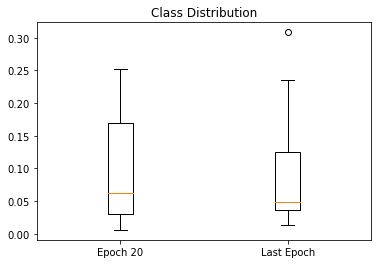

In [54]:
first_dist = [x / 5000 for x in dist[0]]
last_dist = [x / 5000 for x in dist[-1]]
distri_dict = {'Epoch 20':first_dist , 'Last Epoch':last_dist }
fig1, ax1 = plt.subplots()
ax1.set_title('Class Distribution')
ax1.boxplot(distri_dict.values())
ax1.set_xticklabels(distri_dict.keys())

In [55]:
c_0 = []
c_1 = []
c_2 = []
c_3 = []
c_4 = []
c_5 = []
c_6 = []
c_7 = []
c_8 = []
c_9 = []

for step in dist:
    c_0.append(step[0]/5000)
    c_1.append(step[1]/5000)
    c_2.append(step[2]/5000)
    c_3.append(step[3]/5000)
    c_4.append(step[4]/5000)
    c_5.append(step[5]/5000)
    c_6.append(step[6]/5000)
    c_7.append(step[7]/5000)
    c_8.append(step[8]/5000)
    c_9.append(step[9]/5000)

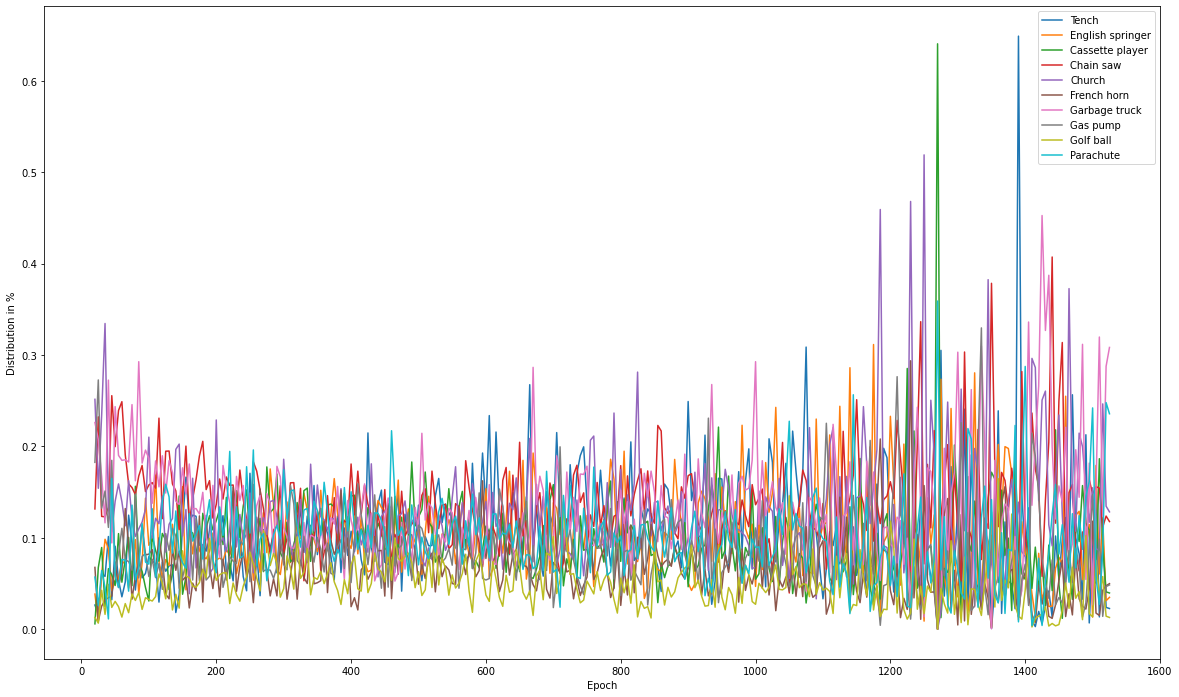

In [56]:
epoch_scale  = range(20,len(dist)*5+20,5)
fig = plt.figure(figsize=(20,12))
plt.plot(epoch_scale, c_0,label="Tench")
plt.plot(epoch_scale, c_1, label="English springer")
plt.plot(epoch_scale, c_2, label="Cassette player")
plt.plot(epoch_scale, c_3, label="Chain saw")
plt.plot(epoch_scale, c_4, label="Church")
plt.plot(epoch_scale, c_5, label="French horn")
plt.plot(epoch_scale, c_6, label="Garbage truck")
plt.plot(epoch_scale, c_7, label="Gas pump")
plt.plot(epoch_scale, c_8, label="Golf ball")
plt.plot(epoch_scale, c_9, label="Parachute")
#fig.suptitle("Class Distribituion per Epoch", fontsize=30)
plt.xlabel('Epoch')
plt.ylabel('Distribution in %')
plt.legend()
plt.show()

In [57]:
c_0 = 0
c_1 = 0
c_2 = 0
c_3 = 0
c_4 = 0
c_5 = 0
c_6 = 0
c_7 = 0
c_8 = 0
c_9 = 0

c_0_o = []
c_1_o = []
c_2_o = []
c_3_o = []
c_4_o = []
c_5_o = []
c_6_o = []
c_7_o = []
c_8_o = []
c_9_o = []

i = 0
for step in dist:
    step = (np.array(step)+0.0000000001) 
    #print(int(list((1/(step/5000))/np.sum(1/(step/5000)))[0]*5000))
    c_0 = c_0 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[0]*(1230*0.8)))
    c_1 = c_1 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[1]*(1230*0.8)))
    c_2 = c_2 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[2]*(1230*0.8)))
    c_3 = c_3 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[3]*(1230*0.8)))
    c_4 = c_4 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[4]*(1230*0.8)))
    c_5 = c_5 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[5]*(1230*0.8)))
    c_6 = c_6 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[6]*(1230*0.8)))
    c_7 = c_7 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[7]*(1230*0.8)))
    c_8 = c_8 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[8]*(1230*0.8)))
    c_9 = c_9 + (int(list((1/(step/5000))/np.sum(1/(step/5000)))[9]*(1230*0.8)))
    sum_all = c_0+ c_1+ c_2+ c_3+ c_4+ c_5+ c_6+ c_7+ c_8+ c_9
    c_0_o.append(c_0/sum_all)
    c_1_o.append(c_1/sum_all)
    c_2_o.append(c_2/sum_all)
    c_3_o.append(c_3/sum_all)
    c_4_o.append(c_4/sum_all)
    c_5_o.append(c_5/sum_all)
    c_6_o.append(c_6/sum_all)
    c_7_o.append(c_7/sum_all)
    c_8_o.append(c_8/sum_all)
    c_9_o.append(c_9/sum_all)

In [58]:
print(c_0, c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8, c_9)
print(c_0_o[-1], c_1_o[-1], c_2_o[-1], c_3_o[-1], c_4_o[-1], c_5_o[-1], c_6_o[-1], c_7_o[-1], c_8_o[-1], c_9_o[-1])

27734 25670 27612 17795 20767 41884 20102 31641 55392 27058
0.09380527980247248 0.08682417006308028 0.09339263668803166 0.060188395257986506 0.07024065211141364 0.14166511643638702 0.06799140890565017 0.10702000642640916 0.18735350323857197 0.09151883106999713


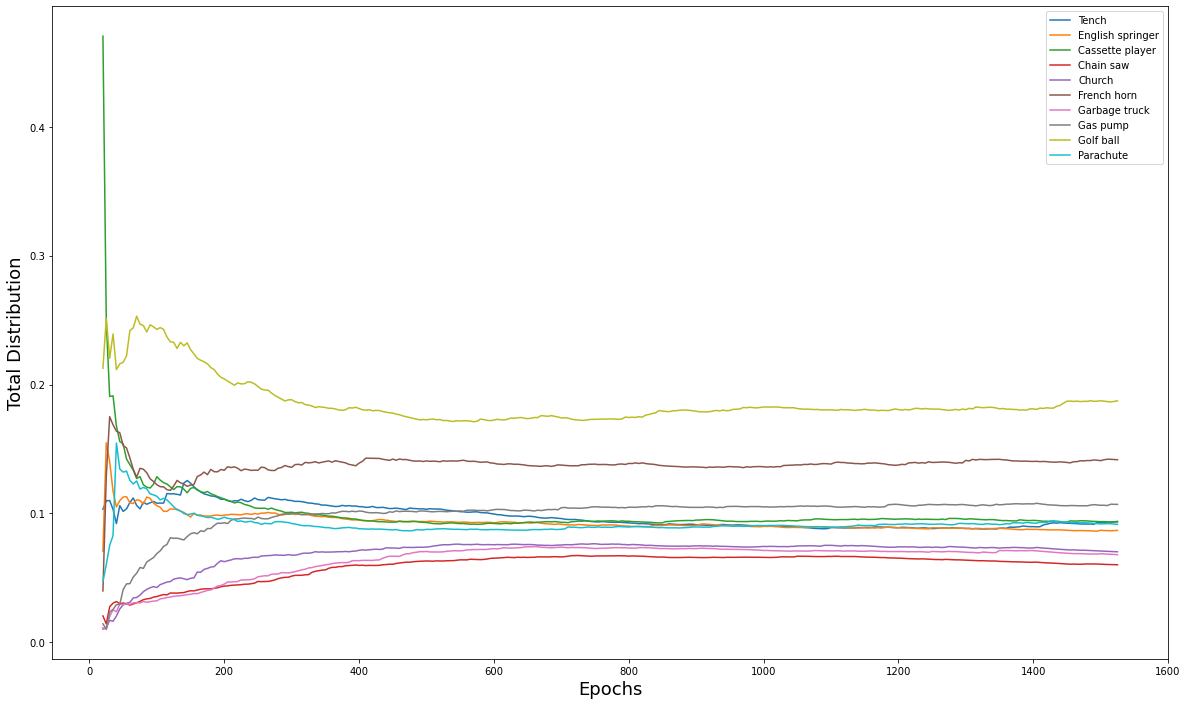

In [59]:
epoch_scale  = range(20,len(dist)*5+20,5)
fig = plt.figure(figsize=(20,12))
plt.plot(epoch_scale, c_0_o,label="Tench")
plt.plot(epoch_scale, c_1_o, label="English springer")
plt.plot(epoch_scale, c_2_o, label="Cassette player")
plt.plot(epoch_scale, c_3_o, label="Chain saw")
plt.plot(epoch_scale, c_4_o, label="Church")
plt.plot(epoch_scale, c_5_o, label="French horn")
plt.plot(epoch_scale, c_6_o, label="Garbage truck")
plt.plot(epoch_scale, c_7_o, label="Gas pump")
plt.plot(epoch_scale, c_8_o, label="Golf ball")
plt.plot(epoch_scale, c_9_o, label="Parachute")
plt.legend()
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Total Distribution', fontsize=18)
plt.show()